In [1]:
import itertools

import keras.layers
import keras.models
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import prophet
import scipy.stats
import seaborn as sns
import sklearn.preprocessing
import statsmodels.tsa.seasonal as seasonal
import statsmodels.tsa.stattools as ts

Importing plotly failed. Interactive plots will not work.


In [2]:
ngd_data = pd.read_csv("../data/daily_NGD.csv", delimiter=",")
ngd_data["Date"] = pd.to_datetime(ngd_data["Date"])
stationary_data = pd.read_csv("../data/daily_NGD_stationary.csv", delimiter=",")
stationary_data["Date"] = pd.to_datetime(stationary_data["Date"])

In [3]:
# Define dependent variables and predictors
dependent_vars = ["NGD", "LDZ", "GTP", "IND"]
predictors = [
    "HDD",
    "HDD-1",
    "Workday",
    "War",
    "Rus",
    "FR nuclear",
    "DE wind",
    "DE solar",
    "THE price",
    "DE IND index",
    "EU storage",
    "EU LNG",
    "UK NL production",
    "Norway sendout",
    "African TAP",
]
# Process the series
all_series = dependent_vars + predictors

In [4]:
# ADF test function
def adf_test(timeseries):
    timeseries = timeseries.dropna()  # Drop NaN values before ADF test
    result = ts.adfuller(timeseries, autolag="AIC")
    return result[1] <= 0.05  # Return True if data is stationary


def kpss_test(series):
    """Runs the KPSS test for stationarity and returns the p-value."""
    statistic, p_value, n_lags, critical_values = ts.kpss(series)
    # Null hypothesis: The data is stationary around a constant.
    return p_value > 0.05  # Returns True if the series is stationary, False otherwise


def make_stationary(series_data):
    # If already stationary
    if adf_test(series_data):
        return series_data, "Already stationary"

    # 2a. First difference
    diff_data = series_data.diff().dropna()
    if adf_test(diff_data):
        return diff_data, "First difference"

    # 2b. log
    log_data = np.log1p(series_data)  # Using log1p to handle 0 values
    if adf_test(log_data):
        return log_data, "Logarithm"

    # 2c. Logarithm and then First Difference
    log_diff_data = log_data.diff().dropna()
    if adf_test(log_diff_data):
        return log_diff_data, "Logarithm then First difference"

    # 2d. seasonal_decompose
    decomposition = seasonal.seasonal_decompose(
        series_data.dropna(), model="additive", freq=365
    )
    residuals = decomposition.resid.dropna()
    if adf_test(residuals):
        # Plotting the components
        decomposition.plot()
        plt.show()
        return residuals, "Seasonal Decompose"

    return series_data, "Still non-stationary"


def create_lstm_model(input_shape):
    model = keras.models.Sequential()
    model.add(keras.layers.LSTM(50, input_shape=input_shape))
    model.add(keras.layers.Dense(1))
    model.compile(loss="mean_squared_error", optimizer="adam")
    return model


def create_dataset(data, look_back=1):
    X, Y = [], []
    for i in range(len(data) - look_back - 1):
        a = data[i : (i + look_back), :]
        X.append(a)
        Y.append(data[i + look_back, 0])
    return np.array(X), np.array(Y)


def calculate_f_statistic(ssr1, ssr2, n, p=1):
    numerator = (ssr1 - ssr2) / p
    denominator = ssr2 / (n - 2 * p)
    return numerator / denominator


def initialize_prophet_model(predictors):
    model = prophet.Prophet()
    for predictor in predictors:
        model.add_regressor(predictor)
    return model


def calculate_ssr(forecast, actual):
    # Ensure both series are aligned by order
    if isinstance(forecast, pd.Series) or isinstance(forecast, pd.DataFrame):
        forecast = forecast.reset_index(drop=True)
        actual = actual.reset_index(drop=True)

    residuals = actual - forecast
    squared_residuals = residuals**2
    sum_squared_residuals = squared_residuals.sum()

    return sum_squared_residuals


def train_test_split(data, test_ratio):
    split_index = int(len(data) * (1 - test_ratio))
    train_data = data[:split_index]
    test_data = data[split_index:]
    return train_data, test_data

In [5]:
# base_predictors = ['HDD', 'HDD-1', 'Workday']
base_predictors = []
other_predictors = [p for p in predictors if p not in base_predictors]

results = []

test_ratio = 0.1  # Set the ratio for test data

# Loop through pairs of dependent variables and predictors
for dep_var, pred in itertools.product(dependent_vars, other_predictors):
    merged_data = ngd_data[["Date", dep_var, pred] + base_predictors].dropna()
    train_data, test_data = train_test_split(merged_data, test_ratio)
    # Model 1
    model1 = initialize_prophet_model(base_predictors)
    model1.fit(train_data.rename(columns={"Date": "ds", dep_var: "y"}))
    forecast1 = model1.predict(test_data.rename(columns={"Date": "ds"}))

    # Model 2
    model2 = initialize_prophet_model(base_predictors + [pred])
    model2.fit(train_data.rename(columns={"Date": "ds", dep_var: "y"}))
    forecast2 = model2.predict(test_data.rename(columns={"Date": "ds"}))

    ssr1 = calculate_ssr(forecast1["yhat"], test_data[dep_var])
    ssr2 = calculate_ssr(forecast2["yhat"], test_data[dep_var])

    f_statistic = calculate_f_statistic(ssr1, ssr2, len(test_data))
    p_value = 1 - scipy.stats.f.cdf(
        f_statistic, 1, len(test_data) - 2
    )  # df1=1, df2=n-2 for your models

    results.append(
        {
            "Dependent Variable": dep_var,
            "Predictor": pred,
            "F-statistic": f_statistic,
            "p-value": p_value,
            "Significant": p_value < 0.05,
        }
    )

# Convert results to a DataFrame
results_df = pd.DataFrame(results)
results_df

16:07:49 - cmdstanpy - INFO - Chain [1] start processing
16:07:49 - cmdstanpy - INFO - Chain [1] done processing
16:07:49 - cmdstanpy - INFO - Chain [1] start processing
16:07:50 - cmdstanpy - INFO - Chain [1] done processing
16:07:50 - cmdstanpy - INFO - Chain [1] start processing
16:07:51 - cmdstanpy - INFO - Chain [1] done processing
16:07:51 - cmdstanpy - INFO - Chain [1] start processing
16:07:51 - cmdstanpy - INFO - Chain [1] done processing
16:07:51 - cmdstanpy - INFO - Chain [1] start processing
16:07:52 - cmdstanpy - INFO - Chain [1] done processing
16:07:52 - cmdstanpy - INFO - Chain [1] start processing
16:07:52 - cmdstanpy - INFO - Chain [1] done processing
16:07:53 - cmdstanpy - INFO - Chain [1] start processing
16:07:53 - cmdstanpy - INFO - Chain [1] done processing
16:07:53 - cmdstanpy - INFO - Chain [1] start processing
16:07:54 - cmdstanpy - INFO - Chain [1] done processing
16:07:54 - cmdstanpy - INFO - Chain [1] start processing
16:07:54 - cmdstanpy - INFO - Chain [1]

Dependent Variable         Predictor  F-statistic       p-value  \
0                 NGD               HDD   404.035125  1.110223e-16   
1                 NGD             HDD-1   324.353221  1.110223e-16   
2                 NGD           Workday     3.113055  7.840810e-02   
3                 NGD               War   154.701695  1.110223e-16   
4                 NGD               Rus   435.318303  1.110223e-16   
5                 NGD        FR nuclear   146.557776  1.110223e-16   
6                 NGD           DE wind    42.962813  1.670796e-10   
7                 NGD          DE solar   -29.155352  1.000000e+00   
8                 NGD         THE price    -0.493475  1.000000e+00   
9                 NGD      DE IND index    47.050112  2.545530e-11   
10                NGD        EU storage   339.384449  1.110223e-16   
11                NGD            EU LNG   -26.858597  1.000000e+00   
12                NGD  UK NL production     2.920778  8.852297e-02   
13                NGD    Norway sendout    -3.332752  1.000000e+00   
14                NGD       African TAP   238.064560  1.110223e-16   
15                LDZ               HDD   577.940603  1.110223e-16   
16                LDZ             HDD-1   459.229745  1.110223e-16   
17                LDZ           Workday    -2.687958  1.000000e+00   
18                LDZ               War   174.390336  1.110223e-16   
19                LDZ               Rus   217.532469  1.110223e-16   
20                LDZ        FR nuclear    68.327772  1.887379e-15   
21                LDZ           DE wind    22.318626  3.173246e-06   
22                LDZ          DE solar   -53.108499  1.000000e+00   
23                LDZ         THE price    -2.923651  1.000000e+00   
24                LDZ      DE IND index   -21.028627  1.000000e+00   
25                LDZ        EU storage   100.015955  1.110223e-16   
26                LDZ            EU LNG   -30.160415  1.000000e+00   
27                LDZ  UK NL production     0.523517  4.699325e-01   
28                LDZ    Norway sendout    -1.775980  1.000000e+00   
29                LDZ       African TAP   168.471788  1.110223e-16   
30                GTP               HDD    63.551446  1.554312e-14   
31                GTP             HDD-1    43.347360  1.398512e-10   
32                GTP           Workday     2.621940  1.061607e-01   
33                GTP               War     1.717453  1.907513e-01   
34                GTP               Rus    -1.232915  1.000000e+00   
35                GTP        FR nuclear   -29.234351  1.000000e+00   
36                GTP           DE wind   183.172194  1.110223e-16   
37                GTP          DE solar     8.171902  4.540764e-03   
38                GTP         THE price   -71.480462  1.000000e+00   
39                GTP      DE IND index   -16.833152  1.000000e+00   
40                GTP        EU storage    -8.071647  1.000000e+00   
41                GTP            EU LNG    -4.156286  1.000000e+00   
42                GTP  UK NL production    -5.902635  1.000000e+00   
43                GTP    Norway sendout    -1.568741  1.000000e+00   
44                GTP       African TAP   -12.599012  1.000000e+00   
45                IND               HDD    68.910256  1.443290e-15   
46                IND             HDD-1    58.927017  1.199041e-13   
47                IND           Workday     6.899168  8.945113e-03   
48                IND               War    81.137891  1.110223e-16   
49                IND               Rus   176.404820  1.110223e-16   
50                IND        FR nuclear    53.702489  1.241784e-12   
51                IND           DE wind     3.372965  6.699462e-02   
52                IND          DE solar   -28.560670  1.000000e+00   
53                IND         THE price   -32.991434  1.000000e+00   
54                IND      DE IND index    23.469478  1.799713e-06   
55                IND        EU storage   218.565104  1.110223e-16   
56           

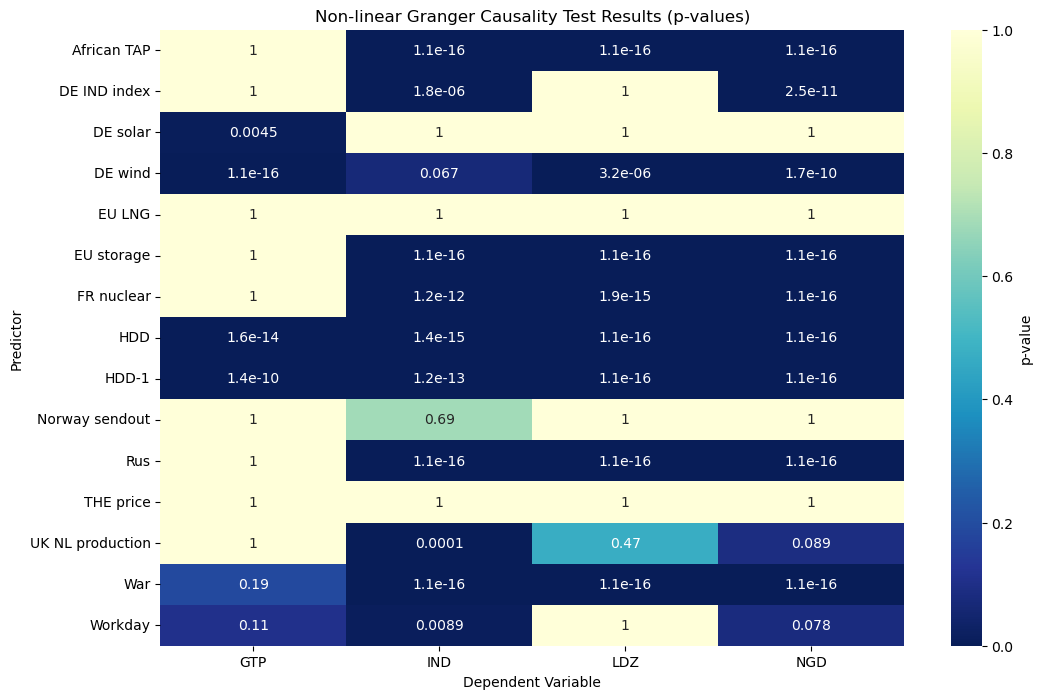

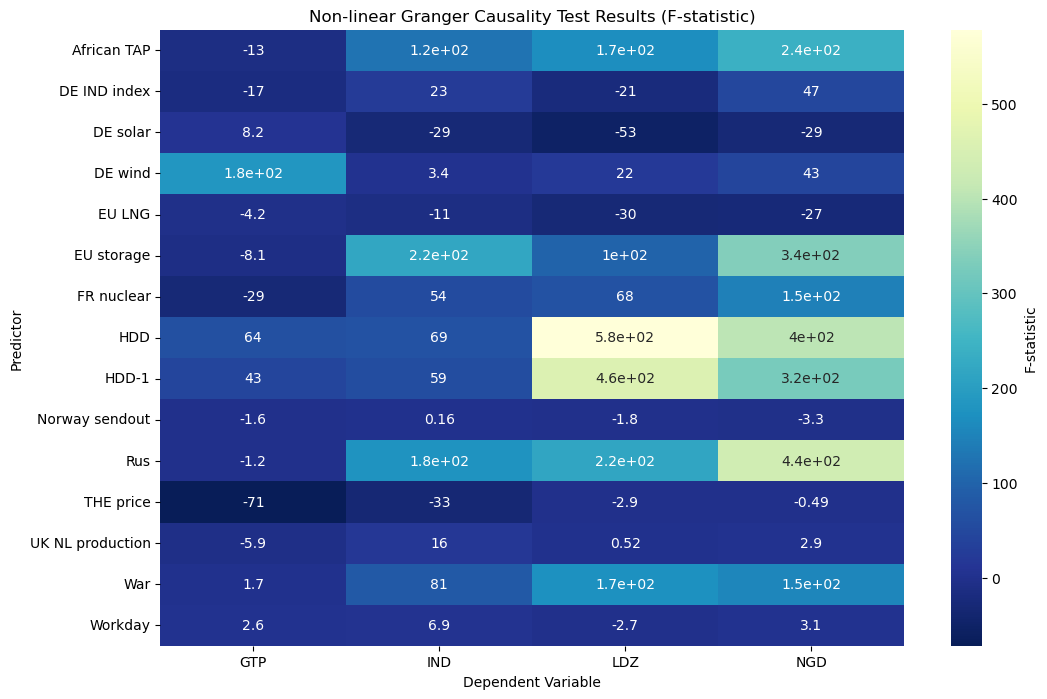

In [6]:
# Plot the results as a heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(
    results_df.pivot(values="p-value", index="Predictor", columns="Dependent Variable"),
    annot=True,
    cmap="YlGnBu_r",
    cbar_kws={"label": "p-value"},
)
plt.title("Non-linear Granger Causality Test Results (p-values)")
plt.show()

# Plot the results as a heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(
    results_df.pivot(
        index="Predictor", columns="Dependent Variable", values="F-statistic"
    ),
    annot=True,
    cmap="YlGnBu_r",
    cbar_kws={"label": "F-statistic"},
)
plt.title("Non-linear Granger Causality Test Results (F-statistic)")
plt.show()

In [7]:
dependent_vars_ = ["NGD"]
predictors_ = ["HDD-1"]
base_predictors = ["HDD"]
other_predictors = [p for p in predictors_ if p not in base_predictors]

results = []
look_back = 1  # number of previous time steps as input (sequence length)
test_ratio = 0.1
epochs = (
    20  # number of epochs for training LSTM, can be increased for better performance
)
batch_size = 10  # number of samples per gradient update, can be optimized

print(
    f"Starting loop for {len(dependent_vars_)} dependent variables and {len(other_predictors)} predictors."
)
for dep_var, pred in itertools.product(dependent_vars_, other_predictors):
    print(f"Processing {dep_var} with predictor {pred}")
    # Prepare data
    merged_data = ngd_data[[dep_var, pred] + base_predictors].dropna()
    train, test = train_test_split(merged_data, test_ratio)

    # Data normalization
    scaler = sklearn.preprocessing.MinMaxScaler(feature_range=(0, 1))
    train_scaled = scaler.fit_transform(train)
    test_scaled = scaler.transform(test)

    # Reshape into X=t and Y=t+1, timestep = look_back
    trainX, trainY = create_dataset(train_scaled, look_back)
    testX, testY = create_dataset(test_scaled, look_back)

    # Check shapes of trainX and testX
    print("trainX shape:", trainX.shape)
    print("testX shape:", testX.shape)

    # Model 1: Base predictors
    model1 = create_lstm_model(
        (look_back, trainX.shape[2])
    )  # the number of features is trainX.shape[2]
    model1.fit(trainX, trainY, epochs=epochs, batch_size=batch_size, verbose=2)

    # Making predictions for Model 1
    trainPredict = model1.predict(trainX)
    testPredict = model1.predict(testX)

    # Inverting scaling for forecast
    testPredict_inv = scaler.inverse_transform(
        np.hstack([testPredict, testX.reshape(-1, 3)[:, 1:]])
    )
    testY_actual_inv = scaler.inverse_transform(
        np.hstack([testY.reshape(-1, 1), testX.reshape(-1, 3)[:, 1:]])
    )

    ssr1 = calculate_ssr(testY_actual_inv[:, 0], testPredict_inv[:, 0])

    # Model 2: Base predictors + additional predictor
    model2 = create_lstm_model((look_back, trainX.shape[2]))
    model2.fit(trainX, trainY, epochs=epochs, batch_size=batch_size, verbose=2)

    # Making predictions for Model 2
    testPredict2 = model2.predict(testX)

    # Inverting scaling for forecast
    testPredict2_inv = scaler.inverse_transform(
        np.hstack([testPredict2, testX.reshape(-1, 3)[:, 1:]])
    )

    ssr2 = calculate_ssr(testY_actual_inv[:, 0], testPredict2_inv[:, 0])

    # Calculate F-statistic and p-value
    f_statistic = calculate_f_statistic(ssr1, ssr2, len(testY))
    p_value = 1 - scipy.stats.f.cdf(
        f_statistic, 1, len(testY) - 2
    )  # df1=1, df2=n-2 for your models

    results.append(
        {
            "Dependent Variable": dep_var,
            "Predictor": pred,
            "F-statistic": f_statistic,
            "p-value": p_value,
            "Significant": p_value < 0.05,
        }
    )
    print(f"Appended data for {dep_var}, {pred}")

# Convert results to a DataFrame and plot heatmaps similar to your existing code
results_df = pd.DataFrame(results)
results_df

Starting loop for 1 dependent variables and 1 predictors.
Processing NGD with predictor HDD-1
trainX shape: (3723, 1, 3)
testX shape: (412, 1, 3)
Epoch 1/20
373/373 - 1s - loss: 0.0148 - 1s/epoch - 3ms/step
Epoch 2/20
373/373 - 0s - loss: 0.0033 - 255ms/epoch - 683us/step
Epoch 3/20
373/373 - 0s - loss: 0.0026 - 253ms/epoch - 679us/step
Epoch 4/20
373/373 - 0s - loss: 0.0022 - 251ms/epoch - 673us/step
Epoch 5/20
373/373 - 0s - loss: 0.0021 - 249ms/epoch - 669us/step
Epoch 6/20
373/373 - 0s - loss: 0.0021 - 251ms/epoch - 672us/step
Epoch 7/20
373/373 - 0s - loss: 0.0020 - 245ms/epoch - 658us/step
Epoch 8/20
373/373 - 0s - loss: 0.0020 - 248ms/epoch - 664us/step
Epoch 9/20
373/373 - 0s - loss: 0.0020 - 244ms/epoch - 655us/step
Epoch 10/20
373/373 - 0s - loss: 0.0020 - 251ms/epoch - 673us/step
Epoch 11/20
373/373 - 0s - loss: 0.0020 - 250ms/epoch - 671us/step
Epoch 12/20
373/373 - 0s - loss: 0.0020 - 251ms/epoch - 673us/step
Epoch 13/20
373/373 - 0s - loss: 0.0020 - 249ms/epoch - 669us/st

Dependent Variable Predictor  F-statistic  p-value  Significant
0                NGD     HDD-1    -2.161147      1.0        False

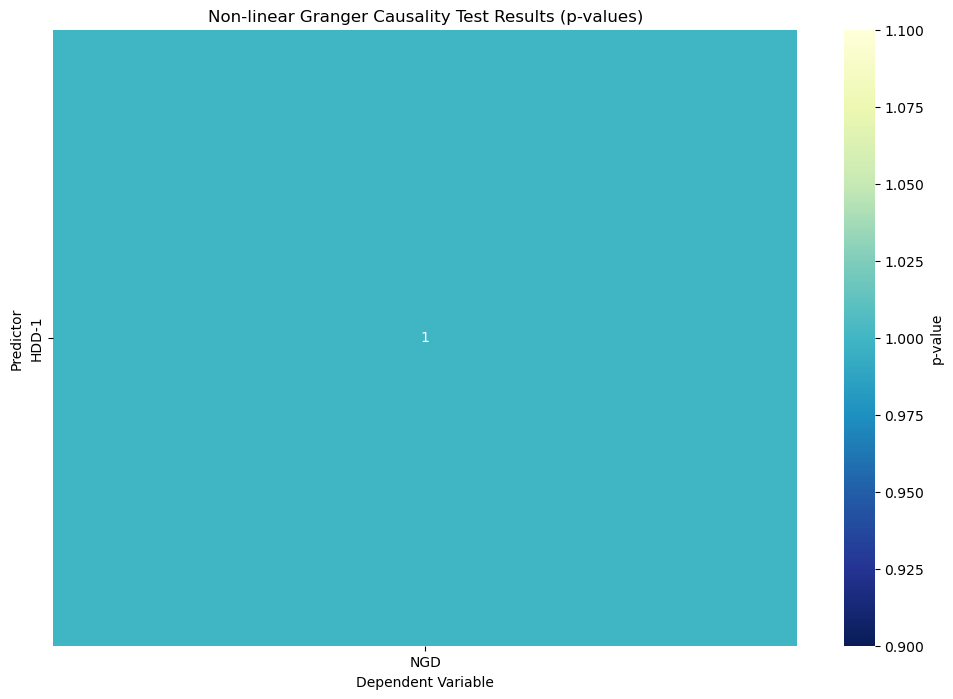

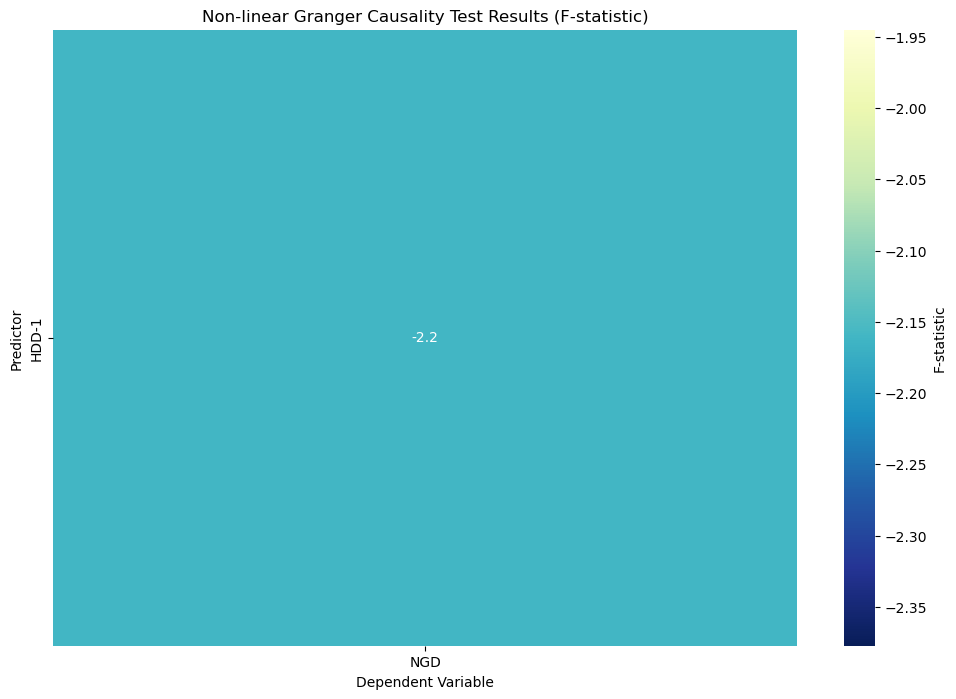

In [8]:
# Check if results_df is not empty before plotting
if not results_df.empty:
    # Plot the results as a heatmap for p-values
    plt.figure(figsize=(12, 8))
    sns.heatmap(
        results_df.pivot(
            index="Predictor", columns="Dependent Variable", values="p-value"
        ),
        annot=True,
        cmap="YlGnBu_r",
        cbar_kws={"label": "p-value"},
    )
    plt.title("Non-linear Granger Causality Test Results (p-values)")
    plt.show()

    # Plot the results as a heatmap for F-statistics
    plt.figure(figsize=(12, 8))
    sns.heatmap(
        results_df.pivot(
            index="Predictor", columns="Dependent Variable", values="F-statistic"
        ),
        annot=True,
        cmap="YlGnBu_r",
        cbar_kws={"label": "F-statistic"},
    )
    plt.title("Non-linear Granger Causality Test Results (F-statistic)")
    plt.show()
else:
    print("No results to display.")

In [78]:
# Convert monthly German industry index to daily

# Read the data
data = pd.read_csv("daily_NGD.csv")

# Convert the 'Date' column to datetime format
data["Date"] = pd.to_datetime(data["Date"])

# Handle duplicate dates by averaging out the values on those dates
data = data.groupby("Date").mean().reset_index()

# Sort data by date
data = data.sort_values("Date").reset_index(drop=True)

# Fill missing dates
all_dates = pd.date_range(start=data["Date"].min(), end=data["Date"].max())
data = (
    data.set_index("Date")
    .reindex(all_dates)
    .reset_index()
    .rename(columns={"index": "Date"})
)

# Set 'DE IND index' to NaN for all but the first day of the month
data.loc[data["Date"].dt.day != 1, "DE IND index"] = None

# Interpolate 'DE IND index' column for daily values using spline interpolation
data["DE IND index"] = data["DE IND index"].interpolate(method="spline", order=3)

# Save the cleaned data
data.to_csv("cleaned_daily_NGD.csv", index=False)

/var/folders/vd/7gcd_vrj2nb1qm1dm3sczg_h0000gn/T/ipykernel_9696/3431199659.py:10: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  data = data.groupby('Date').mean().reset_index()


In [83]:
# Find missing dates
import pandas as pd

# Load the dataset
df = pd.read_csv("daily_NGD.csv", parse_dates=["Date"])

# Sort the dataframe by Date to ensure continuity
df = df.sort_values("Date")

# List of columns to check
columns_to_check = [
    "NGD",
    "LDZ",
    "GTP",
    "IND",
    "HDD",
    "HDD-1",
    "Rus",
    "Workday",
    "War",
    "FR nuclear",
    "DE nuclear",
    "DE wind",
    "DE solar",
    "THE price",
    "DE IND index",
    "EU storage",
    "EU LNG",
    "UK NL production",
    "Norway sendout",
    "African TAP",
]

for col in columns_to_check:
    # Filter out rows where current column is not NaN
    date_range = df[df[col].notna()]["Date"]

    # If date_range is empty, continue to next column
    if date_range.empty:
        print(f"{col} has 0 dates.")
        continue

    # Create a date range from min to max of the current column's non-NaN dates
    full_range = pd.date_range(start=date_range.min(), end=date_range.max())

    # Find missing dates by comparing full_range with actual dates of the column
    missing_dates = full_range.difference(date_range)

    print(f"{col} has {len(date_range)} dates.")
    if not missing_dates.empty:
        print(f"{col} has {len(missing_dates)} missing dates.")
        print()

print("Analysis Complete!")

NGD has 4139 dates.
LDZ has 4139 dates.
GTP has 4139 dates.
IND has 4139 dates.
HDD has 4139 dates.
HDD-1 has 4138 dates.
Rus has 4139 dates.
Workday has 4139 dates.
War has 4139 dates.
FR nuclear has 4139 dates.
DE nuclear has 2502 dates.
DE nuclear has 160 missing dates.

DE wind has 4139 dates.
DE solar has 3134 dates.
THE price has 4139 dates.
DE IND index has 4139 dates.
EU storage has 4139 dates.
EU LNG has 4139 dates.
UK NL production has 2892 dates.
Norway sendout has 882 dates.
African TAP has 4139 dates.
Analysis Complete!


In [81]:
# Fix missing dates

import pandas as pd

# Load the dataset
df = pd.read_csv("daily_NGD.csv", parse_dates=["Date"])

# Sort the dataframe by Date for consistency
df = df.sort_values("Date")

# Interpolate missing values only for the columns in question
columns_to_interpolate = ["DE nuclear", "DE wind", "UK NL production"]
for col in columns_to_interpolate:
    # Only interpolate within the bounds of existing data for the column
    mask = df[col].notna()
    df.loc[mask, col] = df.loc[mask, col].interpolate(
        method="linear", limit_direction="both"
    )

# Save the dataset after handling missing values
df.to_csv("fixed_daily_NGD.csv", index=False)

print("Missing dates for specified columns have been handled!")

Missing dates for specified columns have been handled!


For the pair (NGD, War):
Original NGD is stationary.
Original War is stationary.
--------------------------------------------------
Transformed NGD is stationary. Method used: Already stationary
Transformed War is stationary. Method used: Already stationary


/Users/binbai/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(


For the pair (LDZ, War):
Original LDZ is stationary.
Original War is stationary.
--------------------------------------------------
Transformed LDZ is stationary. Method used: Already stationary
Transformed War is stationary. Method used: Already stationary


/Users/binbai/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(


For the pair (GTP, War):
Original GTP is stationary.
Original War is stationary.
--------------------------------------------------
Transformed GTP is stationary. Method used: Already stationary
Transformed War is stationary. Method used: Already stationary


/Users/binbai/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(


For the pair (IND, War):
Original IND is stationary.
Original War is stationary.
--------------------------------------------------
Transformed IND is stationary. Method used: Already stationary
Transformed War is stationary. Method used: Already stationary


/Users/binbai/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(


          NGD       LDZ       GTP       IND
1    0.107297  0.055763  0.081399  0.619678
2    0.111676  0.047361  0.088499  0.553483
5    0.088768  0.134458  0.135231  0.089254
10   0.612557  0.396977  0.315218  0.713299
50   0.023594  0.000906  0.503829  0.660068
100  0.215581  0.284659  0.635078  0.250043


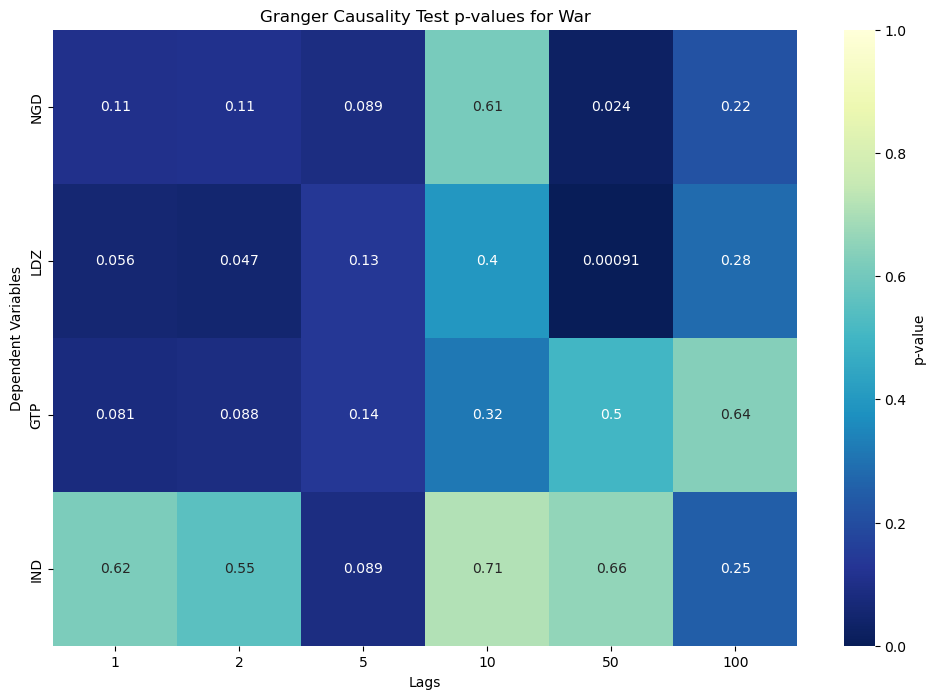

In [5]:
# stationarity test and granger causality test between gas demand and War dummy with different lags to emphasize

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns


# ADF test function
def adf_test(timeseries):
    result = ts.adfuller(timeseries, autolag="AIC")
    return result[1] <= 0.05  # Return True if data is stationary


# Function to make a series stationary and return the method used
def make_stationary(series_data):
    # If already stationary
    if adf_test(series_data):
        return series_data, "Already stationary"

    # First difference
    diff_data = series_data.diff().dropna()
    if adf_test(diff_data):
        return diff_data, "First difference"

    # Log
    log_data = np.log1p(series_data)  # Using log1p to handle 0 values
    if adf_test(log_data):
        return log_data, "Logarithm"

    # Logarithm and then First Difference
    log_diff_data = log_data.diff().dropna()
    if adf_test(log_diff_data):
        return log_diff_data, "Logarithm then First difference"

    return series_data, "Still non-stationary"


# Load and preprocess the data
ngd_data = pd.read_csv("seasonal_decom_stationary_daily_NGD.csv", delimiter=",")
ngd_data["Date"] = pd.to_datetime(ngd_data["Date"])

# Define dependent variables
dependent_vars = ["NGD", "LDZ", "GTP", "IND"]

# Define the subset for which we drop NaN values
subset = "War"
ngd_data.dropna(subset=[subset], inplace=True)

# Make each series stationary using make_stationary
all_series = dependent_vars + [subset]
for series in all_series:
    ngd_data[series], method = make_stationary(ngd_data[series])

# Since transformations might introduce NaN values, we drop those values
ngd_data = ngd_data.replace([np.inf, -np.inf], np.nan).dropna()

# Define the lags and the specific lags to emphasize
emphasis_lags = [1, 2, 5, 10, 50, 100]

results = {}

# Loop over dependent variables to perform the Granger causality test
for dep_var in dependent_vars:
    results[dep_var] = {}
    df = ngd_data[[dep_var, subset]].dropna()

    # Check if the original data is stationary
    is_dep_stationary = adf_test(df[dep_var])
    is_sub_stationary = adf_test(df[subset])

    print(f"For the pair ({dep_var}, {subset}):")
    print(
        f"Original {dep_var} is {'stationary' if is_dep_stationary else 'not stationary'}."
    )
    print(
        f"Original {subset} is {'stationary' if is_sub_stationary else 'not stationary'}."
    )
    print("-" * 50)

    # Use make_stationary right before the Granger Causality Test and inform the method used
    df[dep_var], method_dep = make_stationary(df[dep_var])
    df[subset], method_sub = make_stationary(df[subset])
    df.dropna(inplace=True)

    # Print out the information about the stationarity of each transformed series and the method used
    print(f"Transformed {dep_var} is stationary. Method used: {method_dep}")
    print(f"Transformed {subset} is stationary. Method used: {method_sub}")
    print("=" * 50)

    # Compute Granger causality tests only for emphasis_lags
    test_result = ts.grangercausalitytests(df, maxlag=max(emphasis_lags), verbose=False)

    for lag in emphasis_lags:
        p_value = test_result[lag][0]["ssr_ftest"][1]
        results[dep_var][lag] = p_value

# Convert the results to a DataFrame
results_df = pd.DataFrame(results)

# Display the emphasized results
print(results_df)

# Plotting
plt.figure(figsize=(12, 8))
sns.heatmap(
    results_df.T,
    annot=True,
    cmap="YlGnBu_r",
    vmin=0,
    vmax=1,
    cbar_kws={"label": "p-value"},
)
plt.title(f"Granger Causality Test p-values for {subset}")
plt.xlabel("Lags")
plt.ylabel("Dependent Variables")
plt.show()

The series 'Rus' is not stationary. Taking its logarithm.


/Users/binbai/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
/Users/binbai/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
/Users/binbai/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
/Users/binbai/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(


          NGD       LDZ       GTP       IND
1    0.979575  0.680738  0.742913  0.057703
2    0.504029  0.643282  0.776047  0.027455
5    0.586924  0.864647  0.494911  0.727650
10   0.397138  0.615467  0.207547  0.854773
50   0.966968  0.963500  0.631686  0.949353
100  0.997355  0.993687  0.879234  0.886384


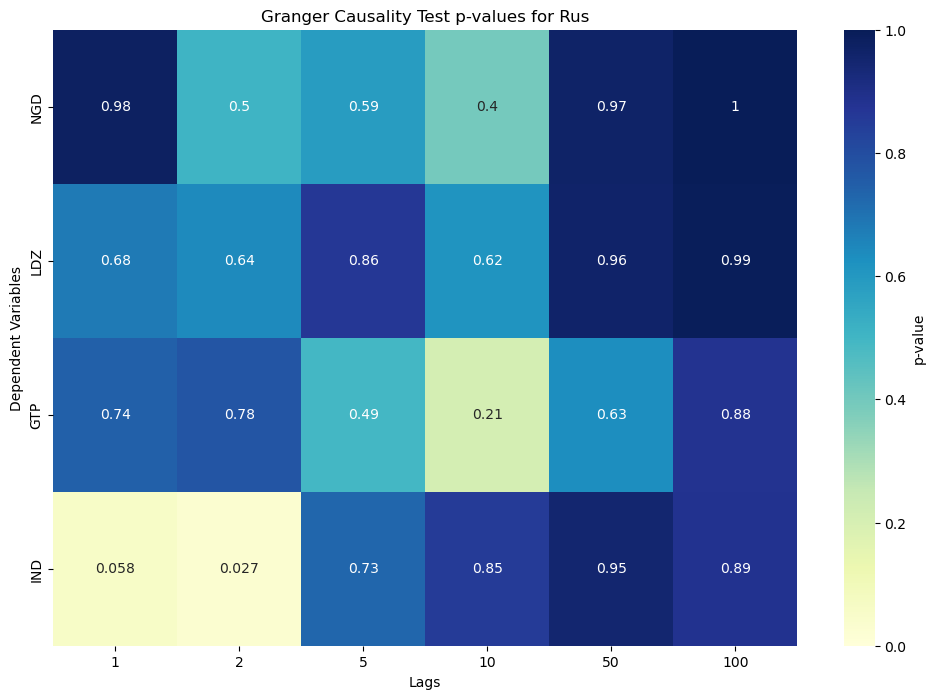

In [1]:
# stationarity test and granger causality test between gas demand and Russian gas flow with different lags to emphasize

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns


# ADF test function
def adf_test(timeseries):
    result = ts.adfuller(timeseries, autolag="AIC")
    return result[1] <= 0.05  # Return True if data is stationary


# Load and preprocess the data
ngd_data = pd.read_csv("daily_NGD.csv", delimiter=",")
ngd_data["Date"] = pd.to_datetime(ngd_data["Date"])

# Define dependent variables
dependent_vars = ["NGD", "LDZ", "GTP", "IND"]

# Define the subset for which we drop NaN values
subset = "Rus"
ngd_data.dropna(subset=[subset], inplace=True)

# Check if each series is stationary, if not take the log
all_series = dependent_vars + [subset]
for series in all_series:
    if not adf_test(ngd_data[series]):
        print(f"The series '{series}' is not stationary. Taking its logarithm.")
        ngd_data[series] = np.log(ngd_data[series])

# Since logarithm might introduce infinite or NaN values (log(0) is undefined), we drop those values
ngd_data = ngd_data.replace([np.inf, -np.inf], np.nan).dropna()

# Define the lags and the specific lags to emphasize
emphasis_lags = [1, 2, 5, 10, 50, 100]

results = {}

# Loop over dependent variables to perform the Granger causality test
for dep_var in dependent_vars:
    results[dep_var] = {}
    df = ngd_data[[dep_var, subset]]

    # Compute Granger causality tests only for emphasis_lags
    test_result = ts.grangercausalitytests(df, maxlag=max(emphasis_lags), verbose=False)

    for lag in emphasis_lags:
        p_value = test_result[lag][0]["ssr_ftest"][1]
        results[dep_var][lag] = p_value

# Convert the results to a DataFrame
results_df = pd.DataFrame(results)

# Display the emphasized results
print(results_df)

# Plotting
plt.figure(figsize=(12, 8))
sns.heatmap(
    results_df.T,
    annot=True,
    cmap="YlGnBu",
    vmin=0,
    vmax=1,
    cbar_kws={"label": "p-value"},
)
plt.title(f"Granger Causality Test p-values for {subset}")
plt.xlabel("Lags")
plt.ylabel("Dependent Variables")
plt.show()

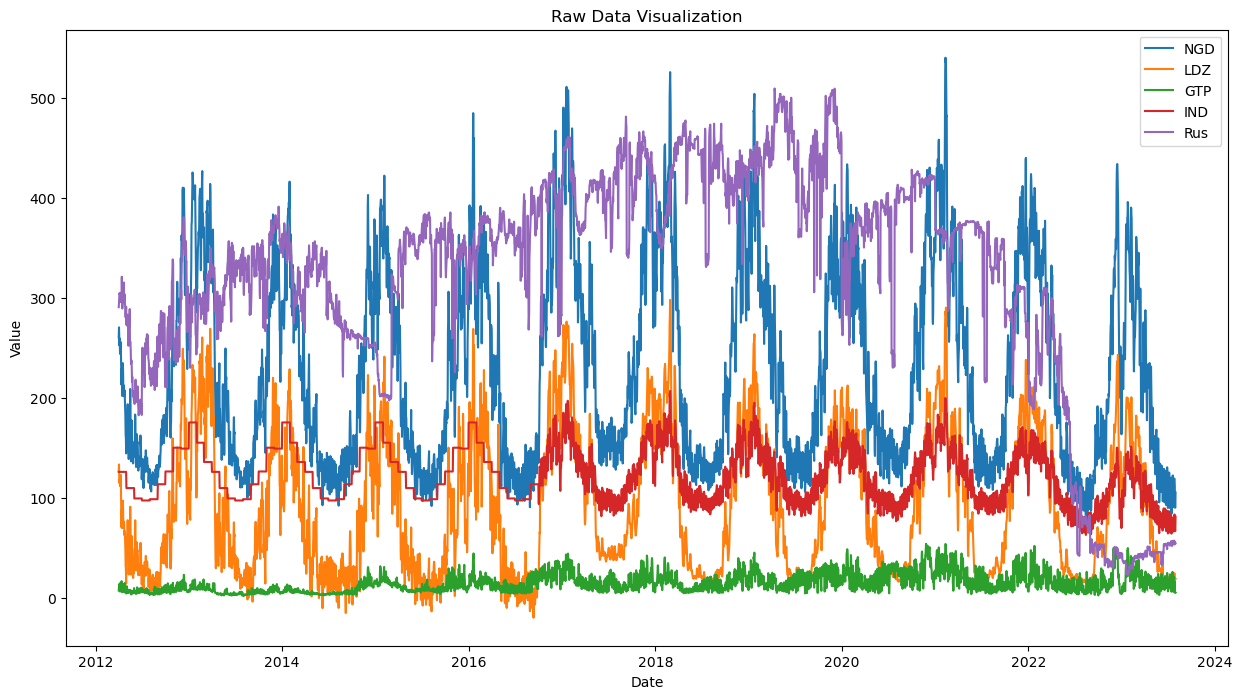

The series 'NGD' is still not stationary after log transformation and differencing.
The series 'LDZ' is still not stationary after log transformation and differencing.
The series 'IND' is still not stationary after log transformation and differencing.


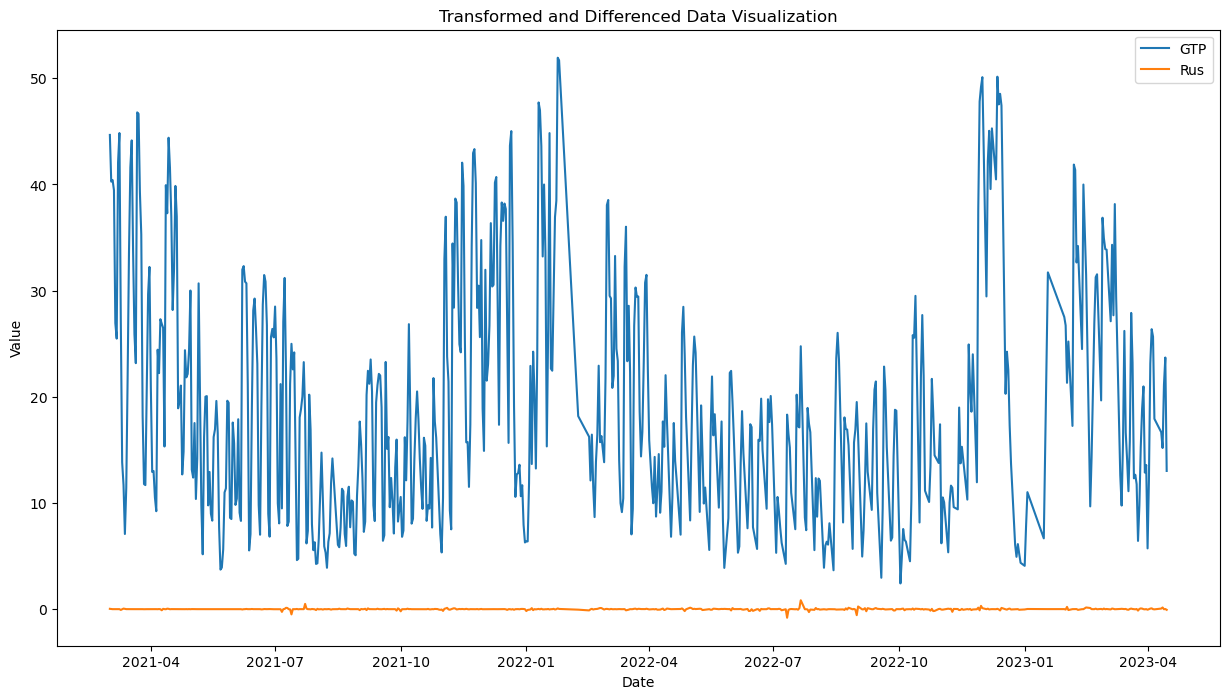

/Users/binbai/anaconda3/envs/YulinMT/lib/python3.9/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
/Users/binbai/anaconda3/envs/YulinMT/lib/python3.9/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
/Users/binbai/anaconda3/envs/YulinMT/lib/python3.9/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
/Users/binbai/anaconda3/envs/YulinMT/lib/python3.9/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(


          NGD       LDZ       GTP       IND
1    0.433557  0.789387  0.397394  0.380723
2    0.648162  0.565294  0.654919  0.226752
5    0.858965  0.755485  0.470224  0.666804
10   0.959169  0.715324  0.535445  0.756222
50   0.596730  0.691885  0.659733  0.360183
100  0.195014  0.282117  0.589990  0.832213


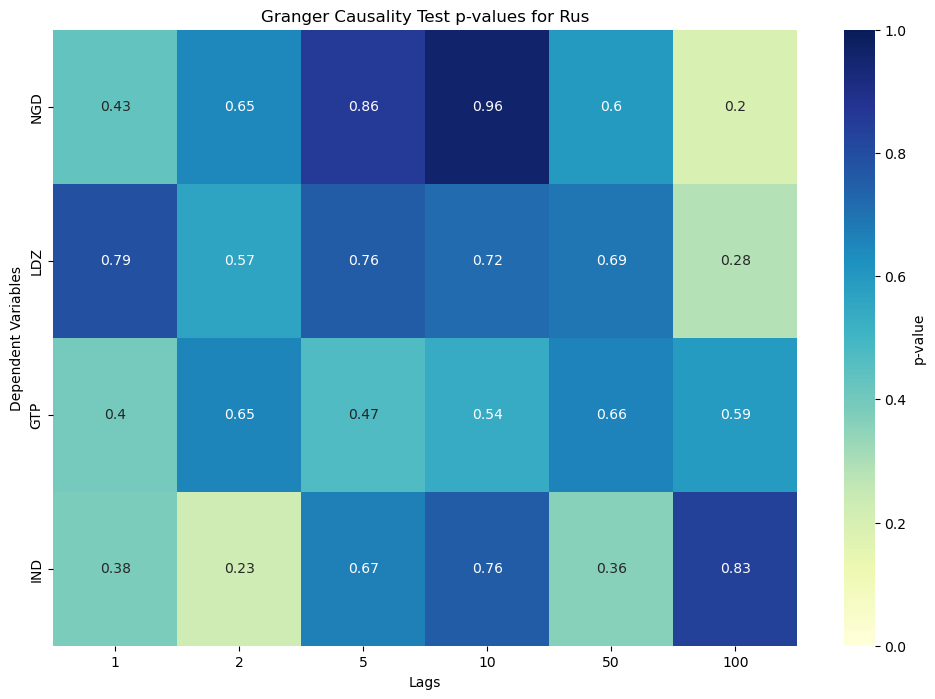

In [53]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns


# ADF test function
def adf_test(timeseries):
    result = ts.adfuller(timeseries, autolag="AIC")
    return result[1] <= 0.05  # Return True if data is stationary


# Load and preprocess the data
ngd_data = pd.read_csv("daily_NGD.csv", delimiter=",")
ngd_data["Date"] = pd.to_datetime(ngd_data["Date"])

# Plotting the raw data for visualization
plt.figure(figsize=(15, 8))
for col in ["NGD", "LDZ", "GTP", "IND", "Rus"]:
    plt.plot(ngd_data["Date"], ngd_data[col], label=col)
plt.title("Raw Data Visualization")
plt.xlabel("Date")
plt.ylabel("Value")
plt.legend()
plt.show()

# Define dependent variables
dependent_vars = ["NGD", "LDZ", "GTP", "IND"]

# Define the subset for which we drop NaN values
subset = "Rus"
ngd_data.dropna(subset=[subset], inplace=True)

# Transform and difference the series if they're not stationary
all_series = dependent_vars + [subset]
for series in all_series:
    if not adf_test(ngd_data[series]):
        ngd_data[series] = np.log(ngd_data[series])
        ngd_data[series] = ngd_data[series].diff()
        ngd_data.dropna(inplace=True)

# Check the stationarity of the new series and visualize
plt.figure(figsize=(15, 8))
for series in all_series:
    if not adf_test(ngd_data[series]):
        print(
            f"The series '{series}' is still not stationary after log transformation and differencing."
        )
    else:
        plt.plot(ngd_data["Date"], ngd_data[series], label=series)
plt.title("Transformed and Differenced Data Visualization")
plt.xlabel("Date")
plt.ylabel("Value")
plt.legend()
plt.show()

# Define the lags and the specific lags to emphasize
emphasis_lags = [1, 2, 5, 10, 50, 100]

results = {}

# Loop over dependent variables to perform the Granger causality test
for dep_var in dependent_vars:
    results[dep_var] = {}
    df = ngd_data[[dep_var, subset]]

    # Compute Granger causality tests only for emphasis_lags
    test_result = ts.grangercausalitytests(df, maxlag=max(emphasis_lags), verbose=False)

    for lag in emphasis_lags:
        p_value = test_result[lag][0]["ssr_ftest"][1]
        results[dep_var][lag] = p_value

# Convert the results to a DataFrame
results_df = pd.DataFrame(results)

# Display the emphasized results
print(results_df)

# Plotting
plt.figure(figsize=(12, 8))
sns.heatmap(
    results_df.T,
    annot=True,
    cmap="YlGnBu",
    vmin=0,
    vmax=1,
    cbar_kws={"label": "p-value"},
)
plt.title(f"Granger Causality Test p-values for {subset}")
plt.xlabel("Lags")
plt.ylabel("Dependent Variables")
plt.show()

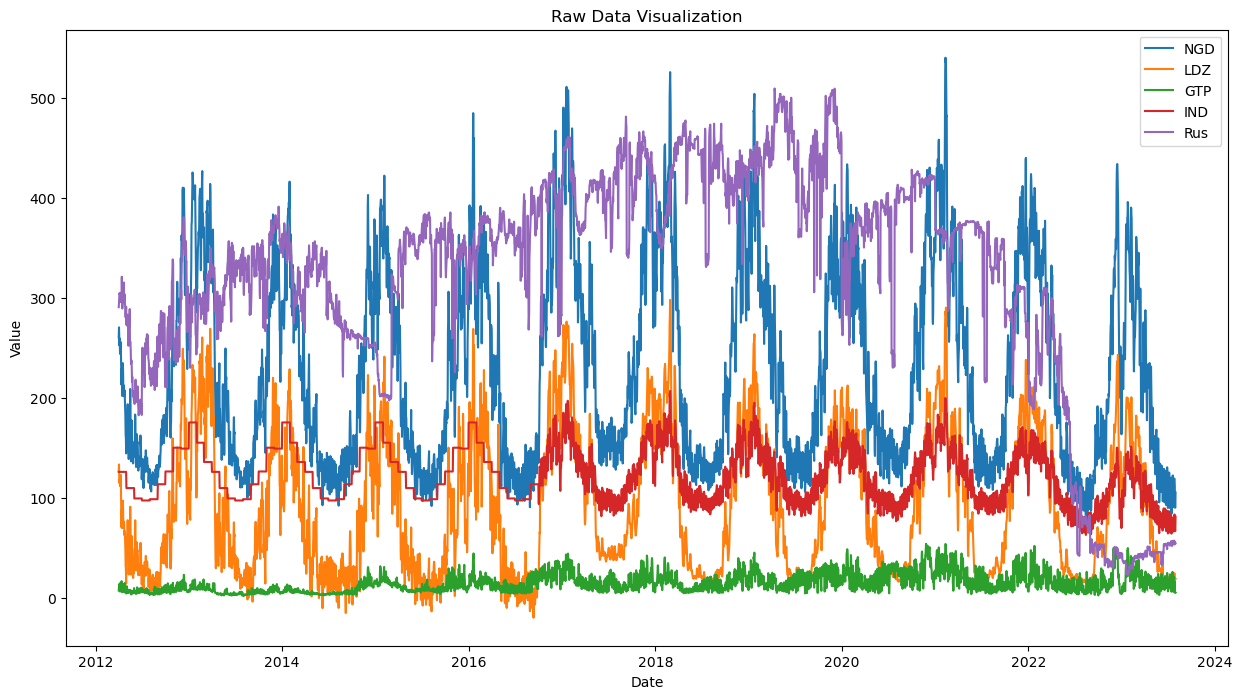

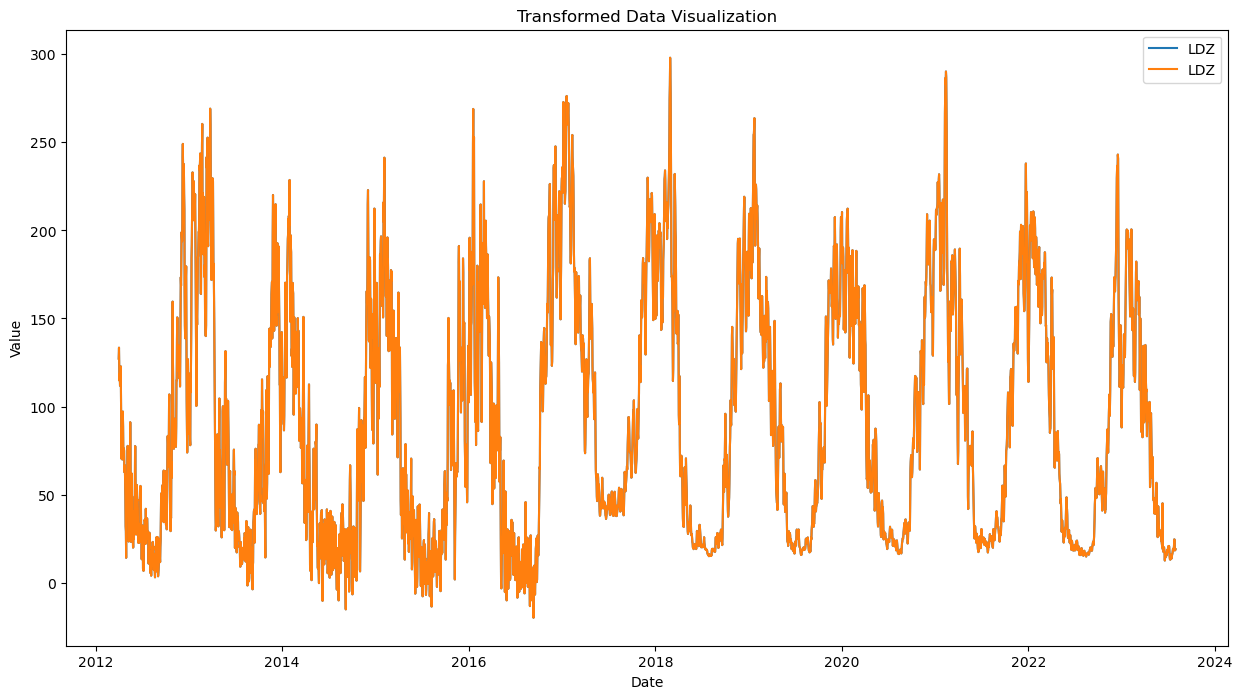

/Users/binbai/anaconda3/envs/YulinMT/lib/python3.9/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(


     LDZ
1    1.0
2    1.0
5    1.0
10   1.0
50   1.0
100  1.0


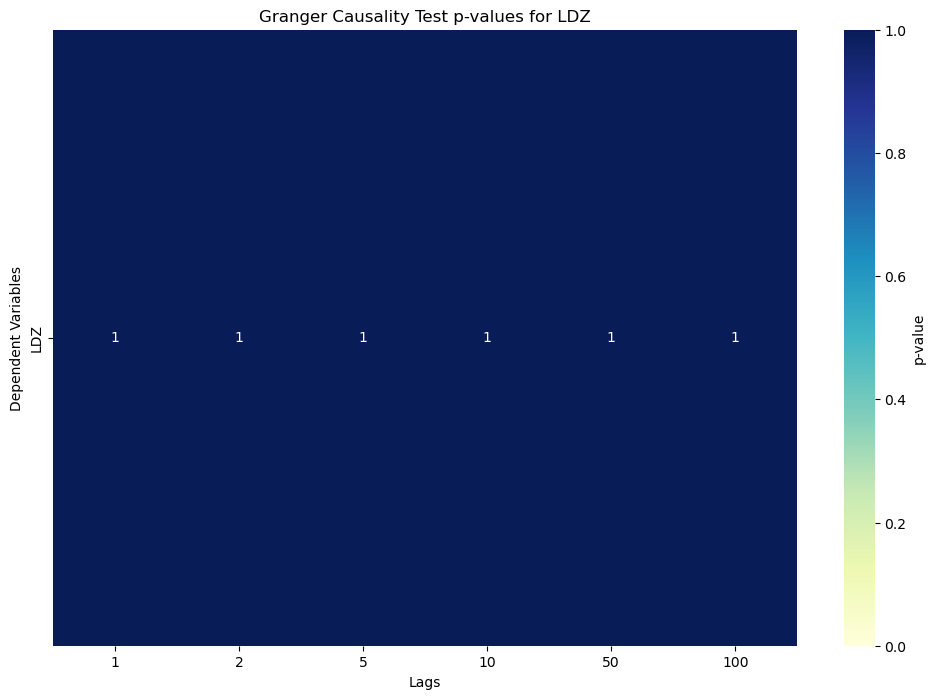

In [66]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from scipy.stats import boxcox


# ADF test function
def adf_test(timeseries):
    result = ts.adfuller(timeseries, autolag="AIC")
    return result[1] <= 0.05  # Return True if data is stationary


# Load and preprocess the data
ngd_data = pd.read_csv("daily_NGD.csv", delimiter=",")
ngd_data["Date"] = pd.to_datetime(ngd_data["Date"])

# Plotting the raw data for visualization
plt.figure(figsize=(15, 8))
for col in ["NGD", "LDZ", "GTP", "IND", "Rus"]:
    plt.plot(ngd_data["Date"], ngd_data[col], label=col)
plt.title("Raw Data Visualization")
plt.xlabel("Date")
plt.ylabel("Value")
plt.legend()
plt.show()

# Define dependent variables
dependent_vars = ["LDZ"]

# Define the subset for which we drop NaN values
subset = "LDZ"
ngd_data.dropna(subset=[subset], inplace=True)

# Transform series if they're not stationary
all_series = dependent_vars + [subset]
for series in all_series:
    if not adf_test(ngd_data[series]):
        ngd_data[series] = np.log(ngd_data[series])
        ngd_data[series] = ngd_data[series].diff()
        ngd_data.dropna(inplace=True)

    if not adf_test(ngd_data[series]):
        decomposition = seasonal.seasonal_decompose(
            ngd_data[series], model="additive", freq=365
        )
        residuals = decomposition.resid.dropna()
        ngd_data[series] = residuals
        ngd_data.dropna(inplace=True)

    if not adf_test(ngd_data[series]):
        ngd_data[series] = ngd_data[series].diff(12)
        ngd_data.dropna(inplace=True)

    if not adf_test(ngd_data[series]):
        ngd_data[series], _ = boxcox(ngd_data[series])

# Check the stationarity of the new series and visualize
plt.figure(figsize=(15, 8))
for series in all_series:
    if not adf_test(ngd_data[series]):
        print(f"The series '{series}' is still not stationary after transformations.")
    else:
        plt.plot(ngd_data["Date"], ngd_data[series], label=series)
plt.title("Transformed Data Visualization")
plt.xlabel("Date")
plt.ylabel("Value")
plt.legend()
plt.show()

# Define the lags and the specific lags to emphasize
emphasis_lags = [1, 2, 5, 10, 50, 100]

results = {}

# Loop over dependent variables to perform the Granger causality test
for dep_var in dependent_vars:
    results[dep_var] = {}
    df = ngd_data[[dep_var, subset]]

    # Compute Granger causality tests only for emphasis_lags
    test_result = ts.grangercausalitytests(df, maxlag=max(emphasis_lags), verbose=False)

    for lag in emphasis_lags:
        p_value = test_result[lag][0]["ssr_ftest"][1]
        results[dep_var][lag] = p_value

# Convert the results to a DataFrame
results_df = pd.DataFrame(results)

# Display the emphasized results
print(results_df)


# Plotting
plt.figure(figsize=(12, 8))
sns.heatmap(
    results_df.T,
    annot=True,
    cmap="YlGnBu",
    vmin=0,
    vmax=1,
    cbar_kws={"label": "p-value"},
)
plt.title(f"Granger Causality Test p-values for {subset}")
plt.xlabel("Lags")
plt.ylabel("Dependent Variables")
plt.show()

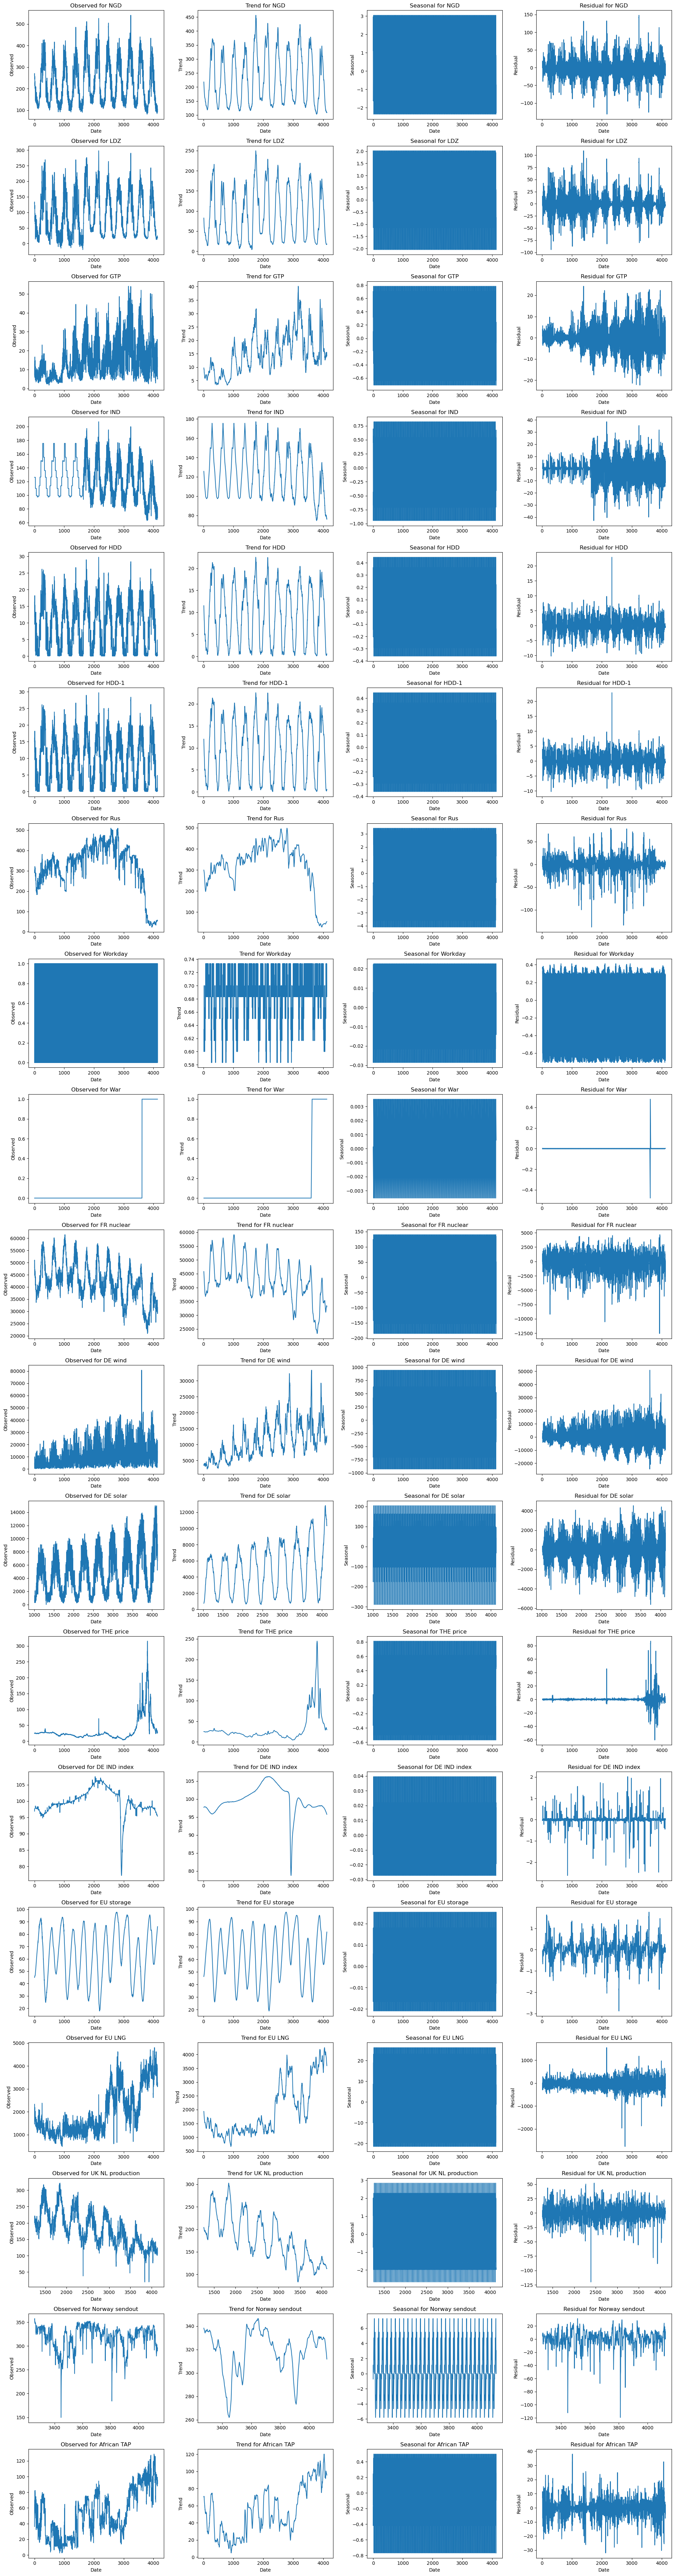

Trend for NGD :
0      NaN
1      NaN
2      NaN
3      NaN
4      NaN
        ..
4134   NaN
4135   NaN
4136   NaN
4137   NaN
4138   NaN
Name: trend, Length: 4139, dtype: float64

Seasonal for NGD :
0       1.116694
1       2.959281
2       2.428146
3       1.706876
4       1.111384
          ...   
4134   -0.018091
4135   -1.717428
4136   -1.726513
4137   -2.280380
4138   -0.765182
Name: seasonal, Length: 4139, dtype: float64

Residual for NGD :
0      NaN
1      NaN
2      NaN
3      NaN
4      NaN
        ..
4134   NaN
4135   NaN
4136   NaN
4137   NaN
4138   NaN
Name: resid, Length: 4139, dtype: float64

Observed for NGD :
0       260.429561
1       270.571811
2       259.802266
3       252.343767
4       259.333501
           ...    
4134    119.143265
4135    111.762820
4136     90.149818
4137     90.307291
4138    105.379126
Name: NGD, Length: 4139, dtype: float64


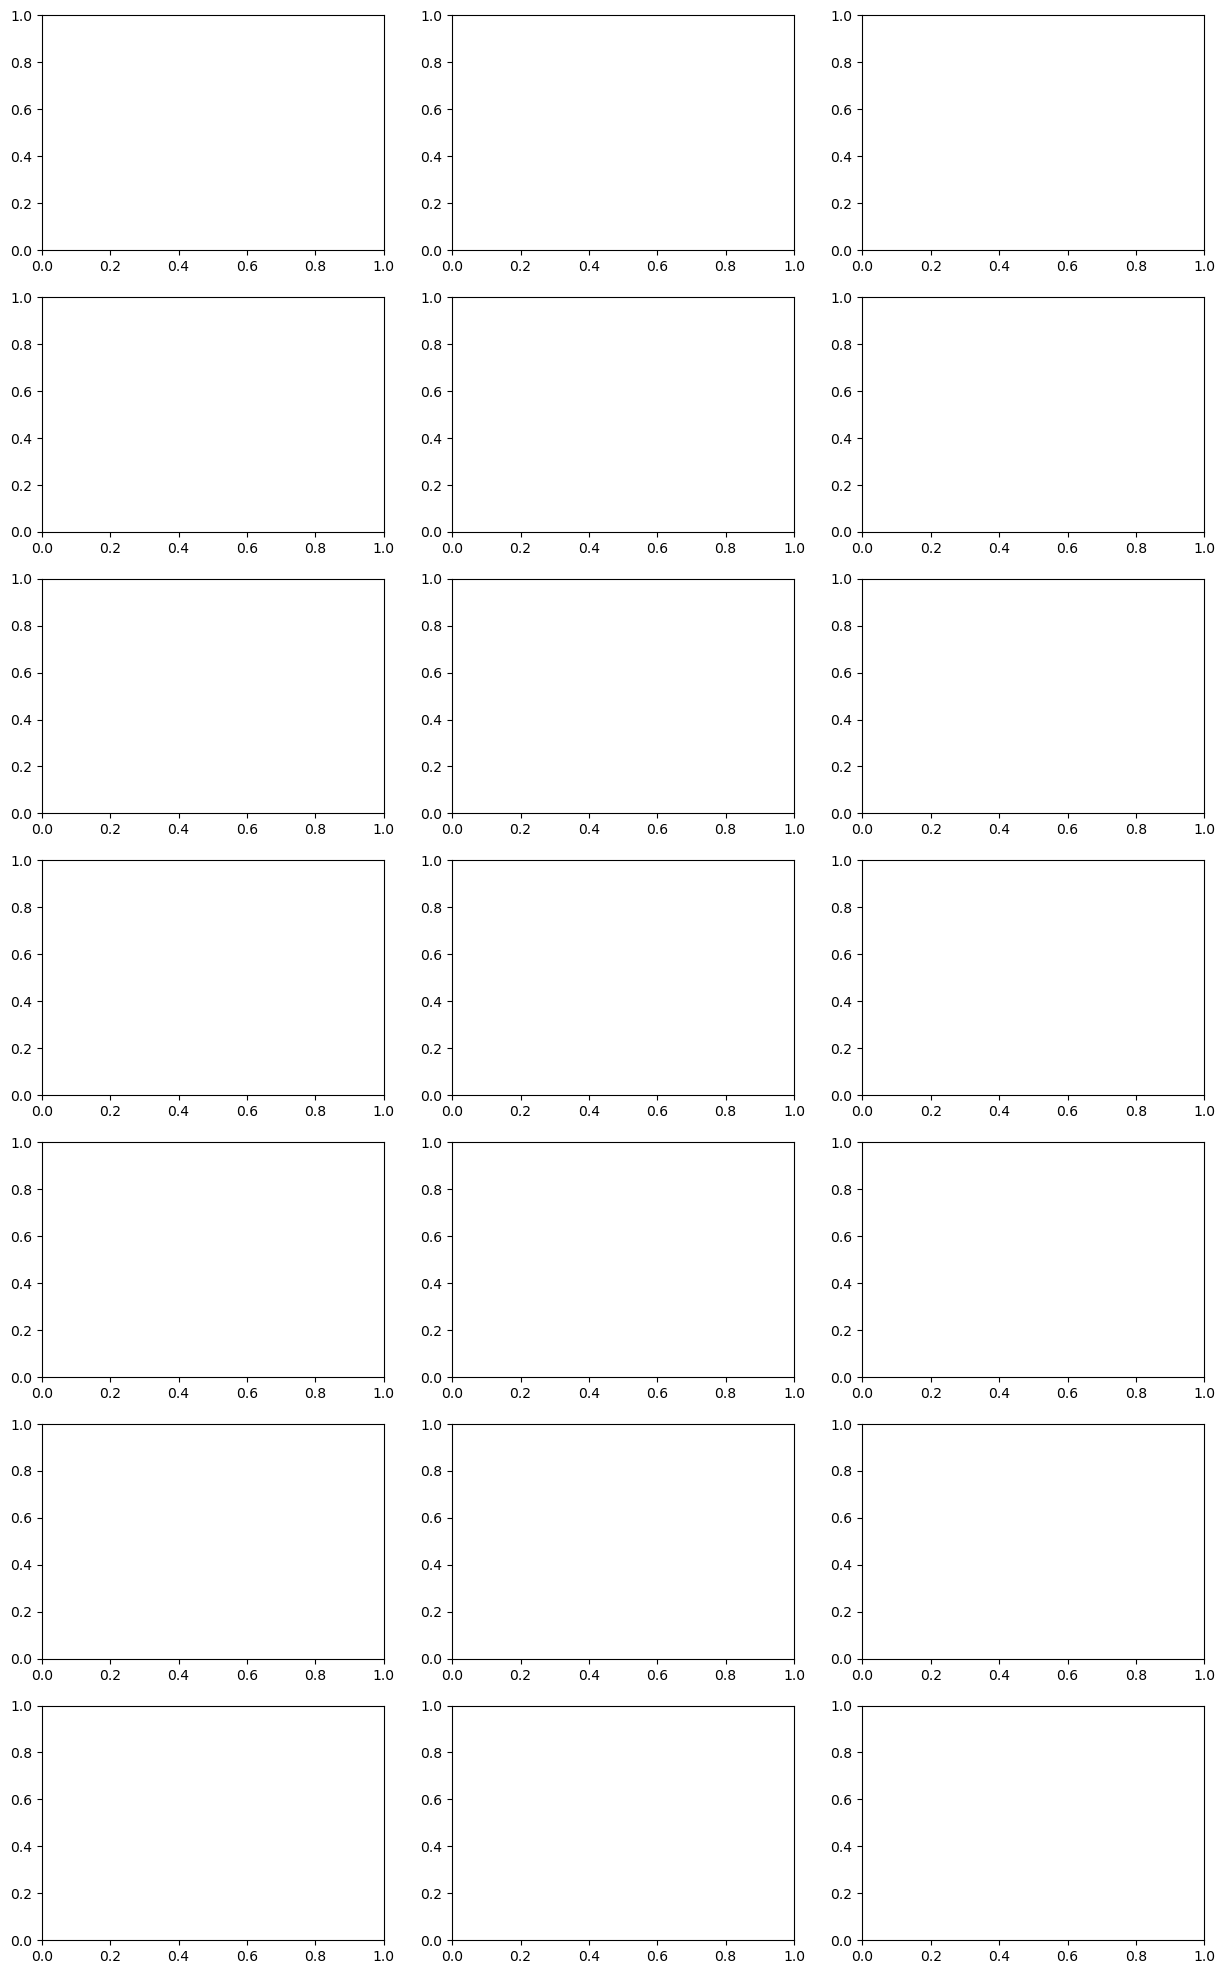

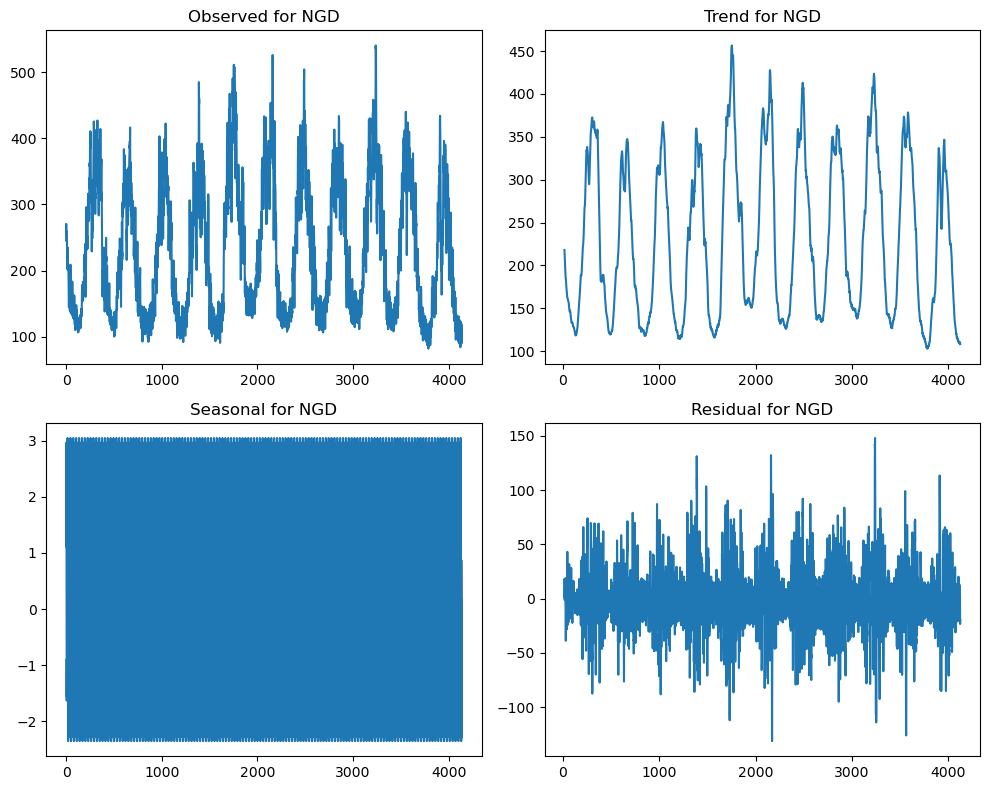

After seasonal decomposition, the residuals for 'NGD' are stationary.
Trend for LDZ :
0      NaN
1      NaN
2      NaN
3      NaN
4      NaN
        ..
4134   NaN
4135   NaN
4136   NaN
4137   NaN
4138   NaN
Name: trend, Length: 4139, dtype: float64

Seasonal for LDZ :
0      -0.054997
1       2.021200
2       1.545428
3       0.680653
4       0.544408
          ...   
4134    0.303017
4135   -1.549930
4136   -1.664246
4137   -2.045930
4138   -0.729709
Name: seasonal, Length: 4139, dtype: float64

Residual for LDZ :
0      NaN
1      NaN
2      NaN
3      NaN
4      NaN
        ..
4134   NaN
4135   NaN
4136   NaN
4137   NaN
4138   NaN
Name: resid, Length: 4139, dtype: float64

Observed for LDZ :
0       127.197376
1       133.410616
2       120.816753
3       114.754796
4       118.820400
           ...    
4134     24.443003
4135     20.187973
4136     18.373506
4137     18.579543
4138     19.024082
Name: LDZ, Length: 4139, dtype: float64


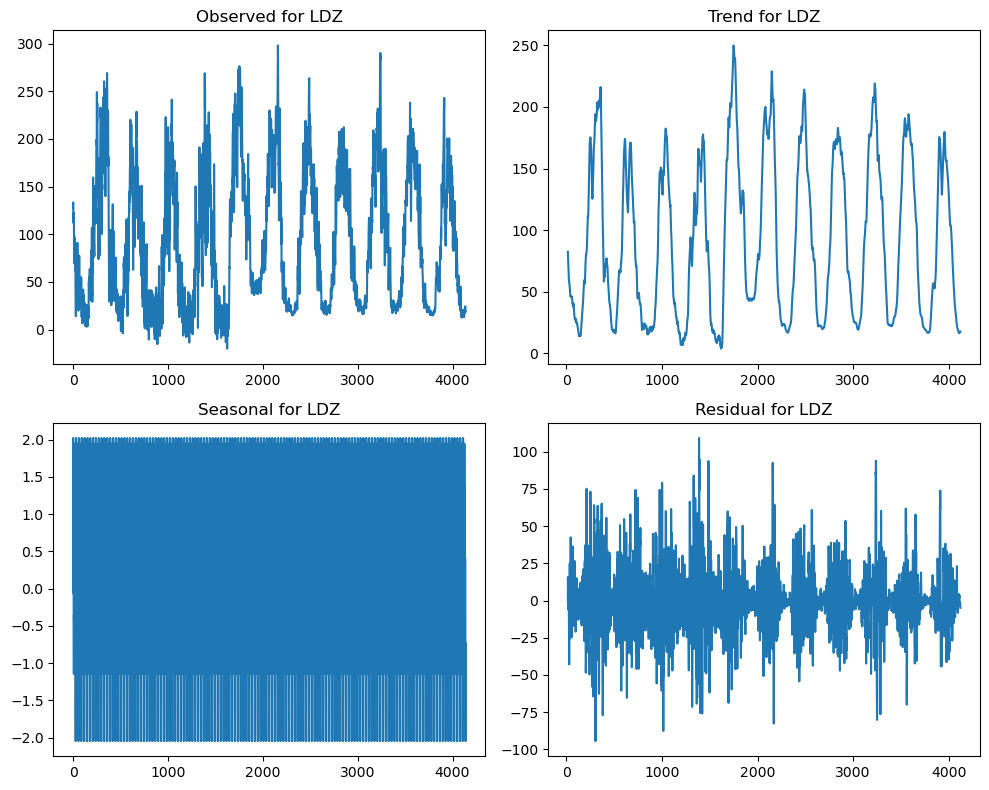

After seasonal decomposition, the residuals for 'LDZ' are stationary.
Trend for GTP :
0      NaN
1      NaN
2      NaN
3      NaN
4      NaN
        ..
4134   NaN
4135   NaN
4136   NaN
4137   NaN
4138   NaN
Name: trend, Length: 4139, dtype: float64

Seasonal for GTP :
0       0.477535
1       0.485975
2       0.317039
3       0.707230
4       0.464979
          ...   
4134   -0.067465
4135    0.244447
4136   -0.004840
4137   -0.556468
4138   -0.707457
Name: seasonal, Length: 4139, dtype: float64

Residual for GTP :
0      NaN
1      NaN
2      NaN
3      NaN
4      NaN
        ..
4134   NaN
4135   NaN
4136   NaN
4137   NaN
4138   NaN
Name: resid, Length: 4139, dtype: float64

Observed for GTP :
0        7.236027
1       11.165036
2       12.989354
3       11.592812
4       14.516942
          ...    
4134    11.295230
4135    16.607405
4136     5.025861
4137     4.961970
4138     5.271691
Name: GTP, Length: 4139, dtype: float64


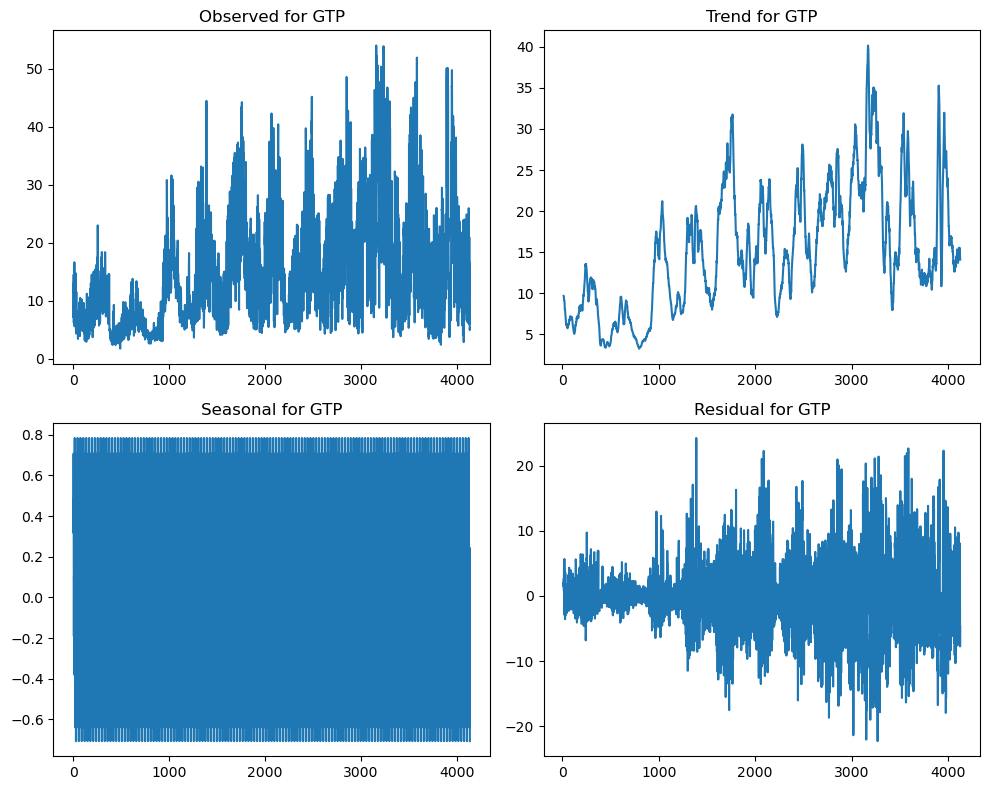

After seasonal decomposition, the residuals for 'GTP' are stationary.
Trend for IND :
0      NaN
1      NaN
2      NaN
3      NaN
4      NaN
        ..
4134   NaN
4135   NaN
4136   NaN
4137   NaN
4138   NaN
Name: trend, Length: 4139, dtype: float64

Seasonal for IND :
0       0.694157
1       0.452106
2       0.565679
3       0.318993
4       0.101997
          ...   
4134   -0.253643
4135   -0.411945
4136   -0.057427
4137    0.322018
4138    0.671984
Name: seasonal, Length: 4139, dtype: float64

Residual for IND :
0      NaN
1      NaN
2      NaN
3      NaN
4      NaN
        ..
4134   NaN
4135   NaN
4136   NaN
4137   NaN
4138   NaN
Name: resid, Length: 4139, dtype: float64

Observed for IND :
0       125.996159
1       125.996159
2       125.996159
3       125.996159
4       125.996159
           ...    
4134     83.405031
4135     74.967442
4136     66.750452
4137     66.765779
4138     81.083352
Name: IND, Length: 4139, dtype: float64


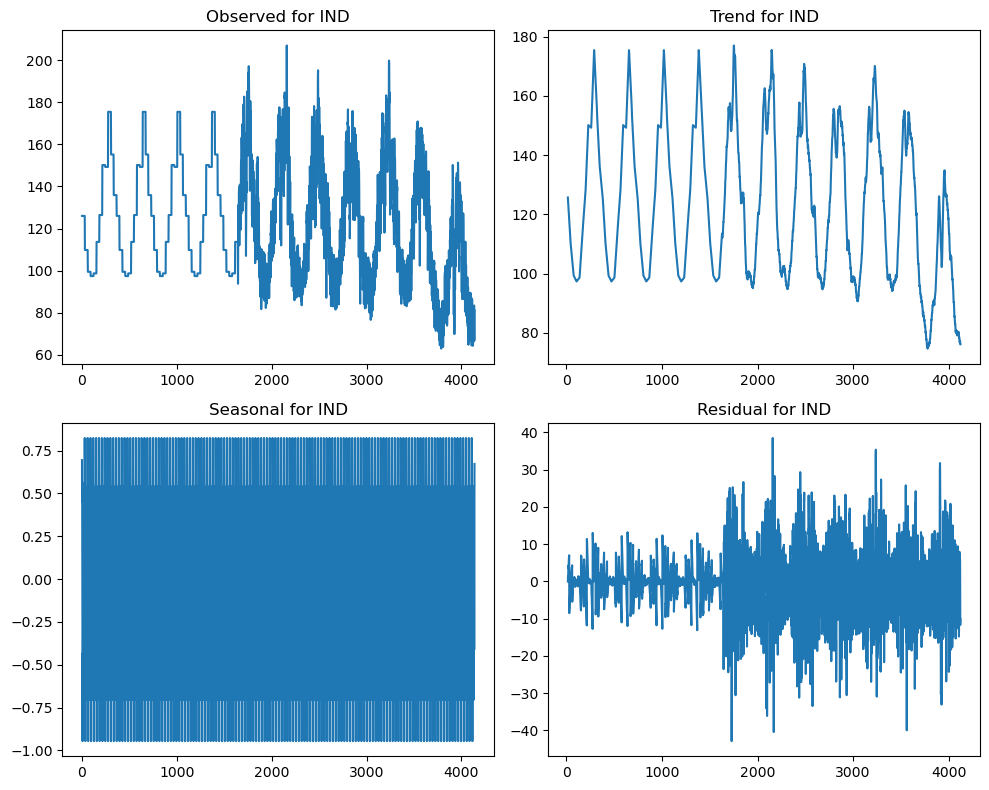

After seasonal decomposition, the residuals for 'IND' are stationary.
Trend for HDD :
0      NaN
1      NaN
2      NaN
3      NaN
4      NaN
        ..
4134   NaN
4135   NaN
4136   NaN
4137   NaN
4138   NaN
Name: trend, Length: 4139, dtype: float64

Seasonal for HDD :
0      -0.142769
1       0.248210
2       0.361743
3       0.101161
4       0.112585
          ...   
4134    0.223600
4135   -0.280379
4136   -0.360739
4137   -0.279276
4138   -0.139256
Name: seasonal, Length: 4139, dtype: float64

Residual for HDD :
0      NaN
1      NaN
2      NaN
3      NaN
4      NaN
        ..
4134   NaN
4135   NaN
4136   NaN
4137   NaN
4138   NaN
Name: resid, Length: 4139, dtype: float64

Observed for HDD :
0       16.265139
1       14.251594
2       11.845219
3       12.582869
4       14.671116
          ...    
4134     2.358150
4135     0.163656
4136     0.159912
4137     0.310793
4138     0.371806
Name: HDD, Length: 4139, dtype: float64


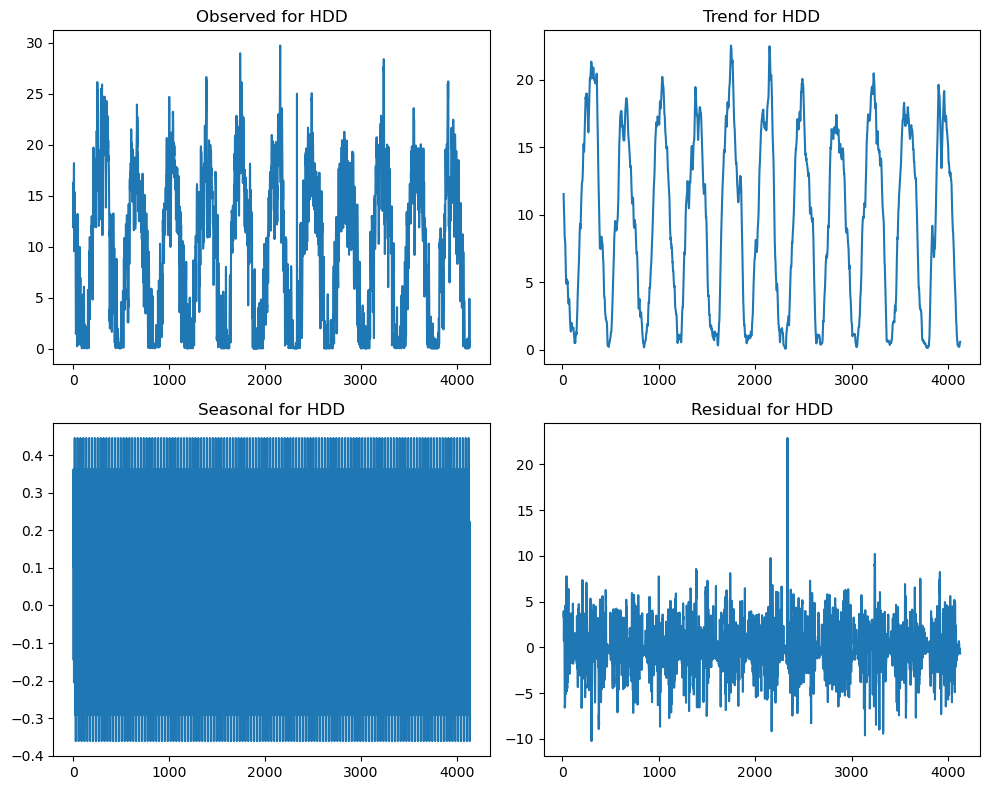

After seasonal decomposition, the residuals for 'HDD' are stationary.
Trend for HDD-1 :
0      NaN
1      NaN
2      NaN
3      NaN
4      NaN
        ..
4134   NaN
4135   NaN
4136   NaN
4137   NaN
4138   NaN
Name: trend, Length: 4139, dtype: float64

Seasonal for HDD-1 :
0      -0.240193
1      -0.143141
2       0.247837
3       0.361370
4       0.100789
          ...   
4134    0.006038
4135    0.223228
4136   -0.280752
4137   -0.361112
4138   -0.279649
Name: seasonal, Length: 4139, dtype: float64

Residual for HDD-1 :
0      NaN
1      NaN
2      NaN
3      NaN
4      NaN
        ..
4134   NaN
4135   NaN
4136   NaN
4137   NaN
4138   NaN
Name: resid, Length: 4139, dtype: float64

Observed for HDD-1 :
0       15.000000
1       16.265139
2       14.251594
3       11.845219
4       12.582869
          ...    
4134     4.887445
4135     2.358150
4136     0.163656
4137     0.159912
4138     0.310793
Name: HDD-1, Length: 4139, dtype: float64


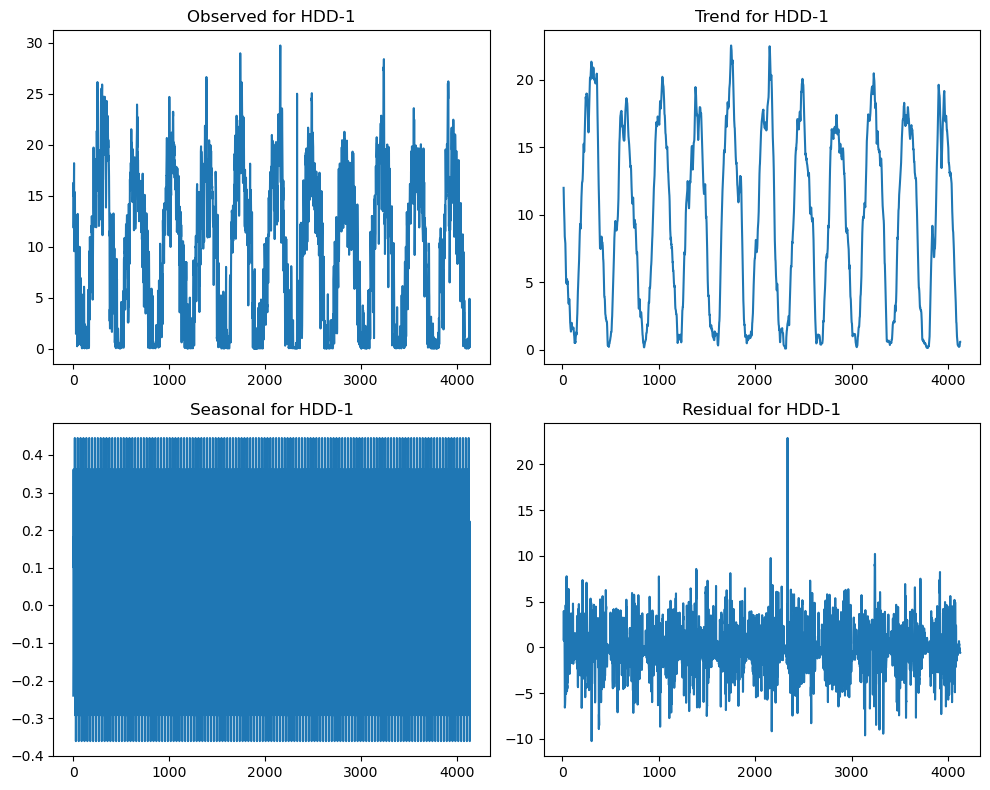

After seasonal decomposition, the residuals for 'HDD-1' are stationary.
Trend for Rus :
0      NaN
1      NaN
2      NaN
3      NaN
4      NaN
        ..
4134   NaN
4135   NaN
4136   NaN
4137   NaN
4138   NaN
Name: trend, Length: 4139, dtype: float64

Seasonal for Rus :
0      -0.764257
1      -0.755035
2      -0.719176
3      -1.189676
4      -4.094544
          ...   
4134    2.987581
4135    1.881180
4136    0.321055
4137   -0.714090
4138   -0.361314
Name: seasonal, Length: 4139, dtype: float64

Residual for Rus :
0      NaN
1      NaN
2      NaN
3      NaN
4      NaN
        ..
4134   NaN
4135   NaN
4136   NaN
4137   NaN
4138   NaN
Name: resid, Length: 4139, dtype: float64

Observed for Rus :
0       290.720800
1       295.694310
2       298.970306
3       304.895313
4       303.265005
           ...    
4134     53.421434
4135     56.294903
4136     55.492658
4137     55.326357
4138     54.527226
Name: Rus, Length: 4139, dtype: float64


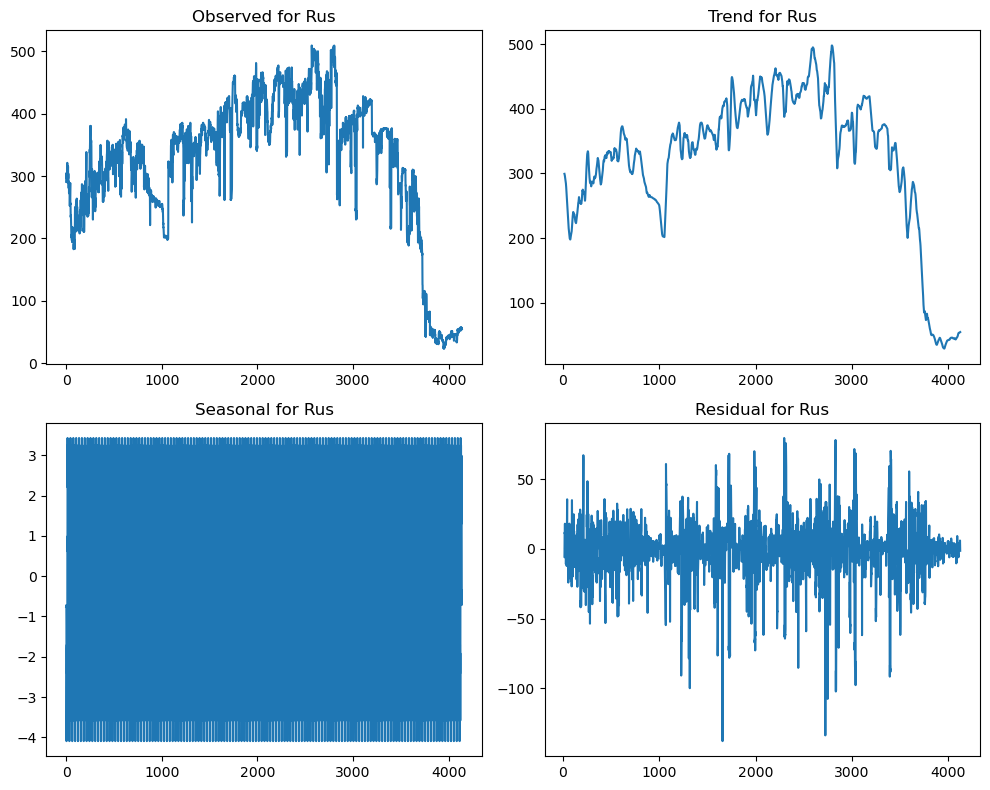

After seasonal decomposition, the residuals for 'Rus' are stationary.
Trend for Workday :
0      NaN
1      NaN
2      NaN
3      NaN
4      NaN
        ..
4134   NaN
4135   NaN
4136   NaN
4137   NaN
4138   NaN
Name: trend, Length: 4139, dtype: float64

Seasonal for Workday :
0       0.000372
1      -0.006928
2       0.000372
3       0.007671
4       0.007793
          ...   
4134   -0.006928
4135    0.000372
4136    0.007671
4137   -0.014105
4138   -0.006684
Name: seasonal, Length: 4139, dtype: float64

Residual for Workday :
0      NaN
1      NaN
2      NaN
3      NaN
4      NaN
        ..
4134   NaN
4135   NaN
4136   NaN
4137   NaN
4138   NaN
Name: resid, Length: 4139, dtype: float64

Observed for Workday :
0       0.0
1       1.0
2       1.0
3       1.0
4       1.0
       ... 
4134    1.0
4135    1.0
4136    0.0
4137    0.0
4138    1.0
Name: Workday, Length: 4139, dtype: float64


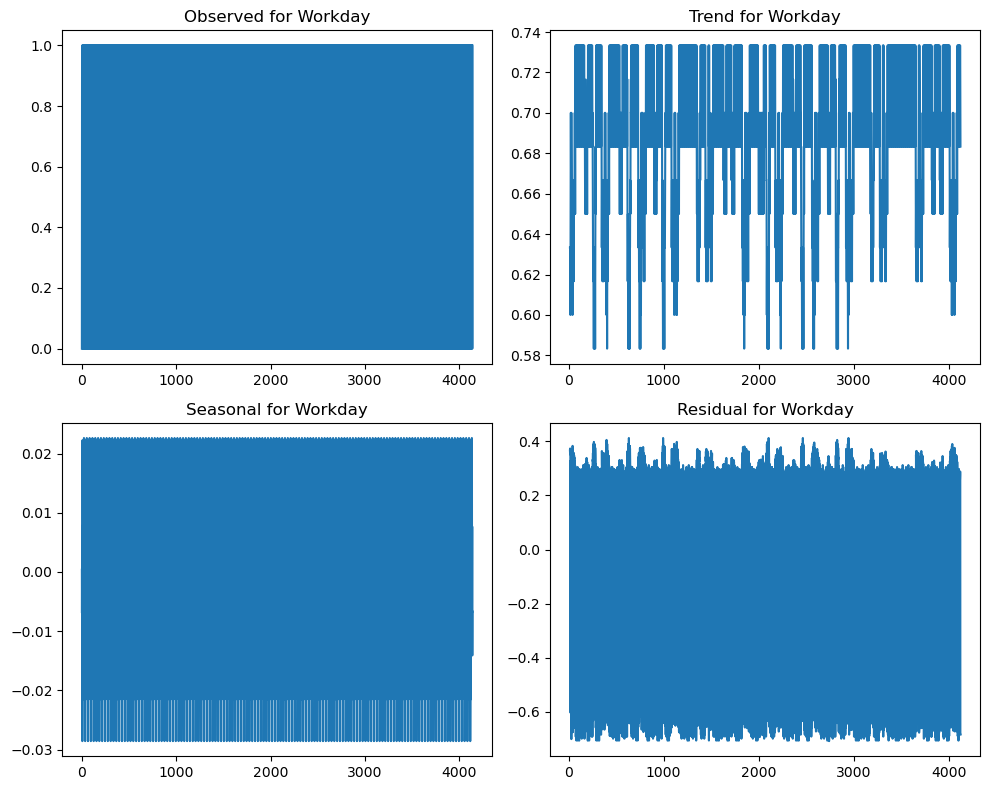

After seasonal decomposition, the residuals for 'Workday' are stationary.
Trend for War :
0      NaN
1      NaN
2      NaN
3      NaN
4      NaN
        ..
4134   NaN
4135   NaN
4136   NaN
4137   NaN
4138   NaN
Name: trend, Length: 4139, dtype: float64

Seasonal for War :
0       0.000122
1      -0.000121
2      -0.000364
3      -0.000607
4      -0.000851
          ...   
4134    0.001582
4135    0.001339
4136    0.001096
4137    0.000852
4138    0.000609
Name: seasonal, Length: 4139, dtype: float64

Residual for War :
0      NaN
1      NaN
2      NaN
3      NaN
4      NaN
        ..
4134   NaN
4135   NaN
4136   NaN
4137   NaN
4138   NaN
Name: resid, Length: 4139, dtype: float64

Observed for War :
0       0.0
1       0.0
2       0.0
3       0.0
4       0.0
       ... 
4134    1.0
4135    1.0
4136    1.0
4137    1.0
4138    1.0
Name: War, Length: 4139, dtype: float64


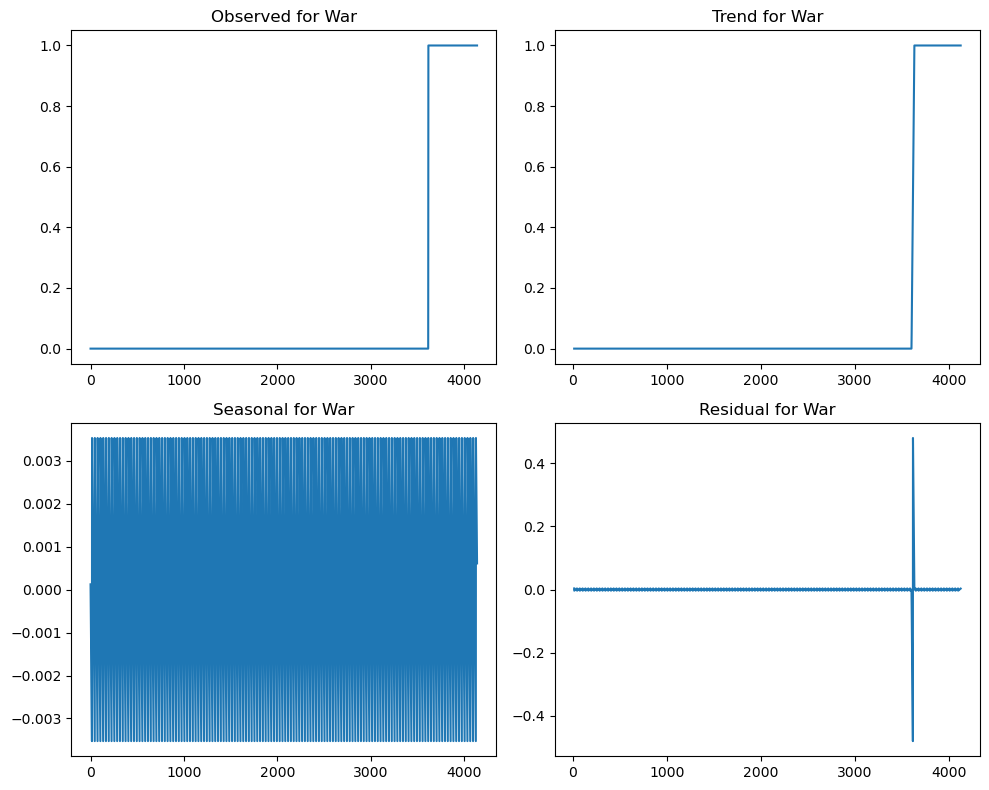

After seasonal decomposition, the residuals for 'War' are stationary.
Trend for FR nuclear :
0      NaN
1      NaN
2      NaN
3      NaN
4      NaN
        ..
4134   NaN
4135   NaN
4136   NaN
4137   NaN
4138   NaN
Name: trend, Length: 4139, dtype: float64

Seasonal for FR nuclear :
0        -9.920107
1       124.336219
2        90.901548
3         7.995100
4      -107.064754
           ...    
4134   -152.605143
4135     51.056171
4136   -131.385192
4137   -161.946384
4138   -185.234462
Name: seasonal, Length: 4139, dtype: float64

Residual for FR nuclear :
0      NaN
1      NaN
2      NaN
3      NaN
4      NaN
        ..
4134   NaN
4135   NaN
4136   NaN
4137   NaN
4138   NaN
Name: resid, Length: 4139, dtype: float64

Observed for FR nuclear :
0       47682.0
1       51006.0
2       50442.0
3       50989.0
4       48934.0
         ...   
4134    33429.0
4135    31652.0
4136    31187.0
4137    29057.0
4138    31660.0
Name: FR nuclear, Length: 4139, dtype: float64


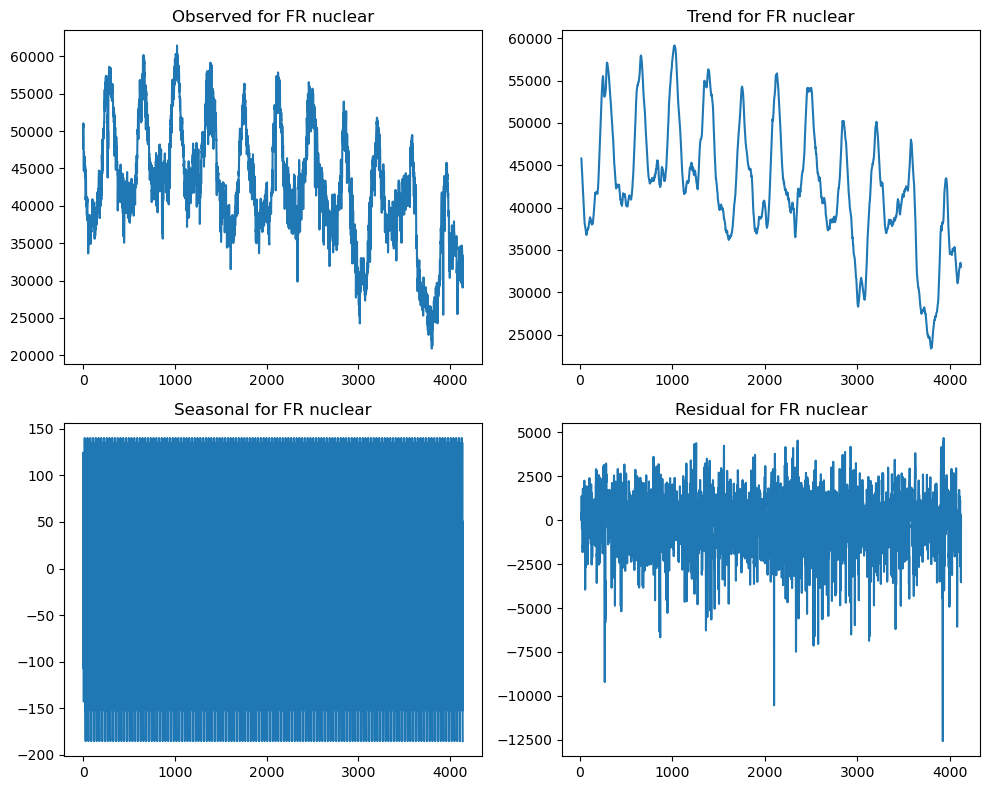

After seasonal decomposition, the residuals for 'FR nuclear' are stationary.
Trend for DE wind :
0      NaN
1      NaN
2      NaN
3      NaN
4      NaN
        ..
4134   NaN
4135   NaN
4136   NaN
4137   NaN
4138   NaN
Name: trend, Length: 4139, dtype: float64

Seasonal for DE wind :
0      -700.813420
1      -376.892058
2      -269.750038
3       418.333295
4       -10.454819
           ...    
4134   -333.432836
4135   -293.655014
4136    523.513709
4137    386.801422
4138     31.889281
Name: seasonal, Length: 4139, dtype: float64

Residual for DE wind :
0      NaN
1      NaN
2      NaN
3      NaN
4      NaN
        ..
4134   NaN
4135   NaN
4136   NaN
4137   NaN
4138   NaN
Name: resid, Length: 4139, dtype: float64

Observed for DE wind :
0        4869.3
1        1087.1
2         895.7
3        5783.3
4        2238.7
         ...   
4134    14933.0
4135     4939.0
4136     8907.0
4137    21415.0
4138    22293.0
Name: DE wind, Length: 4139, dtype: float64


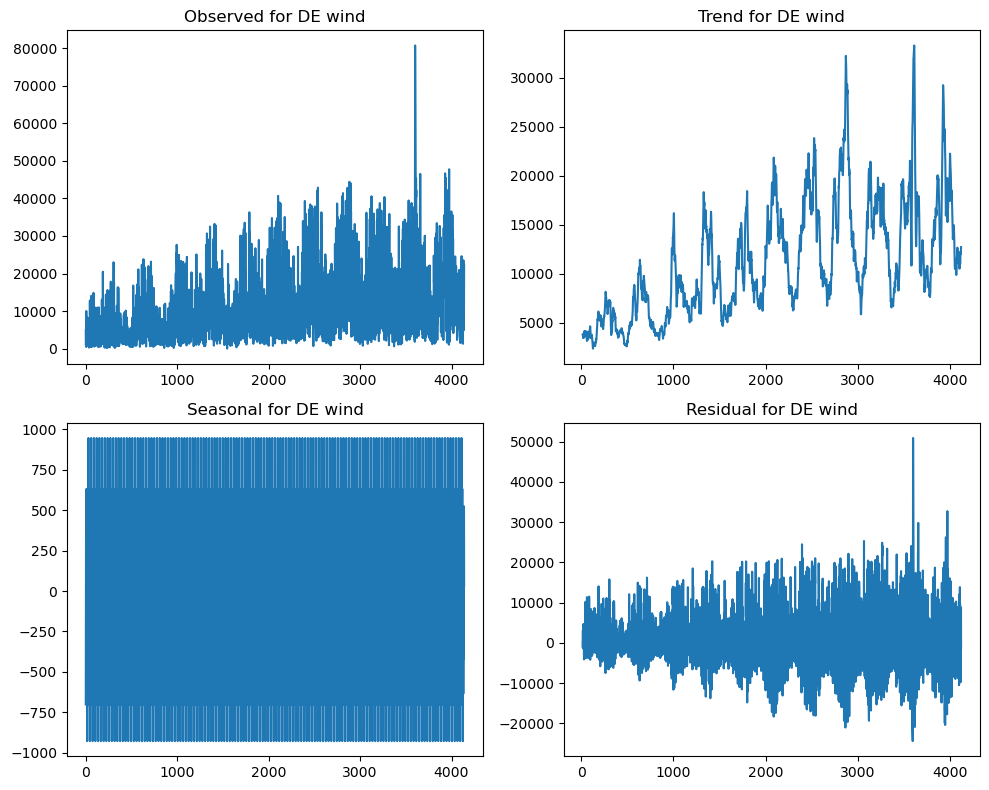

After seasonal decomposition, the residuals for 'DE wind' are stationary.
Trend for DE solar :
1005   NaN
1006   NaN
1007   NaN
1008   NaN
1009   NaN
        ..
4134   NaN
4135   NaN
4136   NaN
4137   NaN
4138   NaN
Name: trend, Length: 3134, dtype: float64

Seasonal for DE solar :
1005     41.935483
1006   -176.240099
1007    -22.307704
1008     19.953186
1009     25.785419
           ...    
4134     -4.075843
4135     96.051875
4136     -1.481960
4137    -32.885779
4138     40.740386
Name: seasonal, Length: 3134, dtype: float64

Residual for DE solar :
1005   NaN
1006   NaN
1007   NaN
1008   NaN
1009   NaN
        ..
4134   NaN
4135   NaN
4136   NaN
4137   NaN
4138   NaN
Name: resid, Length: 3134, dtype: float64

Observed for DE solar :
1005     711.7
1006     323.3
1007     301.4
1008     832.6
1009    1105.1
         ...  
4134    5200.1
4135    7237.5
4136    8194.2
4137    9177.1
4138    6645.6
Name: DE solar, Length: 3134, dtype: float64


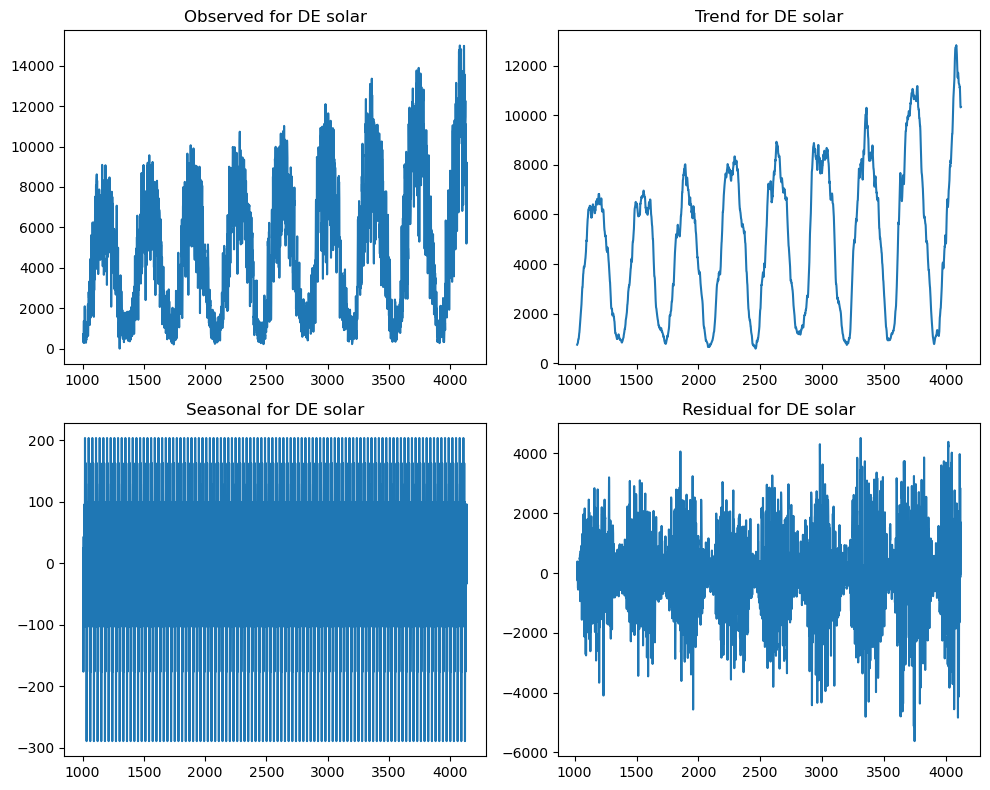

After seasonal decomposition, the residuals for 'DE solar' are stationary.
Trend for THE price :
0      NaN
1      NaN
2      NaN
3      NaN
4      NaN
        ..
4134   NaN
4135   NaN
4136   NaN
4137   NaN
4138   NaN
Name: trend, Length: 4139, dtype: float64

Seasonal for THE price :
0       0.064131
1      -0.303753
2      -0.365955
3      -0.099733
4      -0.242081
          ...   
4134    0.521106
4135    0.613123
4136    0.464436
4137    0.452161
4138    0.428317
Name: seasonal, Length: 4139, dtype: float64

Residual for THE price :
0      NaN
1      NaN
2      NaN
3      NaN
4      NaN
        ..
4134   NaN
4135   NaN
4136   NaN
4137   NaN
4138   NaN
Name: resid, Length: 4139, dtype: float64

Observed for THE price :
0       24.300
1       25.550
2       24.550
3       24.800
4       25.025
         ...  
4134    28.400
4135    25.600
4136    25.600
4137    25.600
4138    26.900
Name: THE price, Length: 4139, dtype: float64


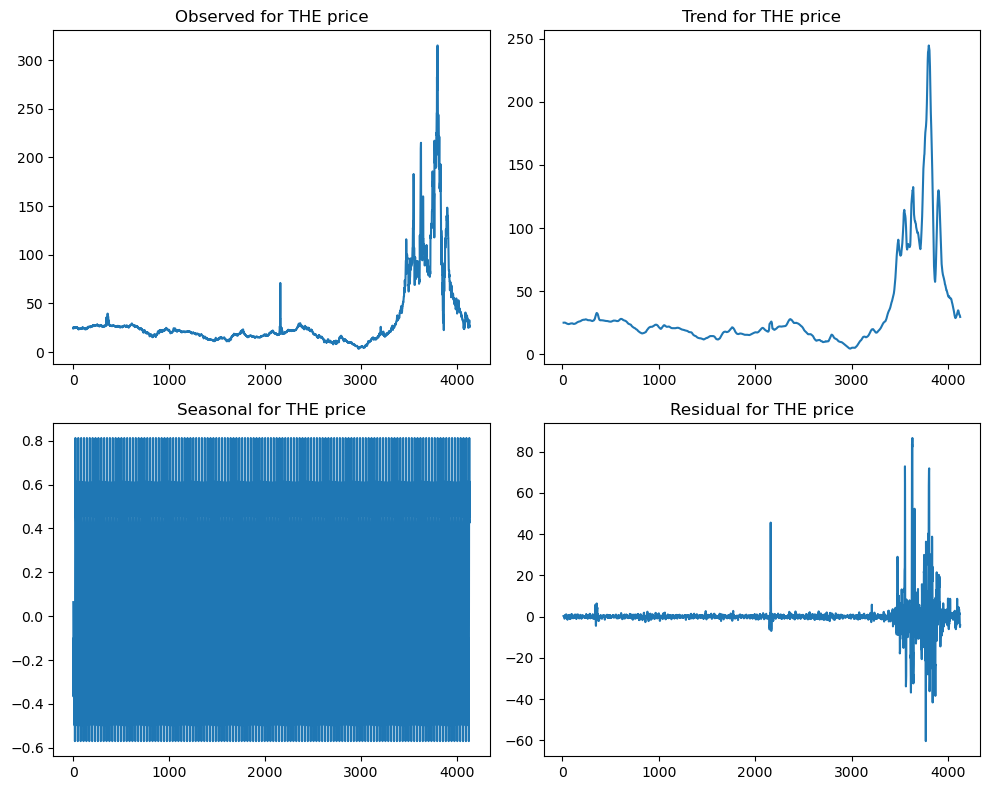

After seasonal decomposition, the residuals for 'THE price' are stationary.
Trend for DE IND index :
0      NaN
1      NaN
2      NaN
3      NaN
4      NaN
        ..
4134   NaN
4135   NaN
4136   NaN
4137   NaN
4138   NaN
Name: trend, Length: 4139, dtype: float64

Seasonal for DE IND index :
0       0.019010
1       0.003524
2      -0.013266
3       0.002224
4      -0.009497
          ...   
4134   -0.000786
4135   -0.019509
4136   -0.017823
4137    0.010447
4138    0.021837
Name: seasonal, Length: 4139, dtype: float64

Residual for DE IND index :
0      NaN
1      NaN
2      NaN
3      NaN
4      NaN
        ..
4134   NaN
4135   NaN
4136   NaN
4137   NaN
4138   NaN
Name: resid, Length: 4139, dtype: float64

Observed for DE IND index :
0       96.900000
1       97.609071
2       97.619969
3       97.630598
4       97.640958
          ...    
4134    95.476104
4135    95.447685
4136    95.419080
4137    95.390286
4138    95.361305
Name: DE IND index, Length: 4139, dtype: float64


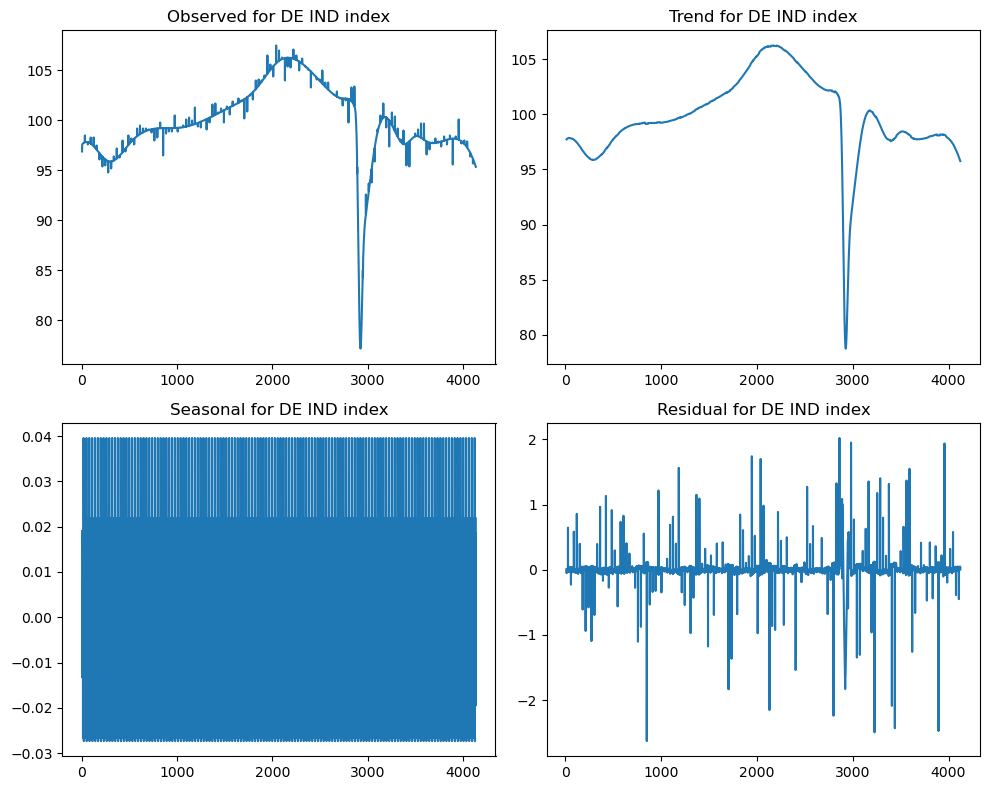

After seasonal decomposition, the residuals for 'DE IND index' are stationary.
Trend for EU storage :
0      NaN
1      NaN
2      NaN
3      NaN
4      NaN
        ..
4134   NaN
4135   NaN
4136   NaN
4137   NaN
4138   NaN
Name: trend, Length: 4139, dtype: float64

Seasonal for EU storage :
0       0.005767
1       0.001353
2      -0.015964
3      -0.004290
4      -0.009400
          ...   
4134    0.017426
4135   -0.008101
4136    0.025439
4137    0.007964
4138   -0.006443
Name: seasonal, Length: 4139, dtype: float64

Residual for EU storage :
0      NaN
1      NaN
2      NaN
3      NaN
4      NaN
        ..
4134   NaN
4135   NaN
4136   NaN
4137   NaN
4138   NaN
Name: resid, Length: 4139, dtype: float64

Observed for EU storage :
0       44.94
1       44.98
2       45.07
3       45.15
4       45.25
        ...  
4134    84.77
4135    85.03
4136    85.40
4137    85.79
4138    86.09
Name: EU storage, Length: 4139, dtype: float64


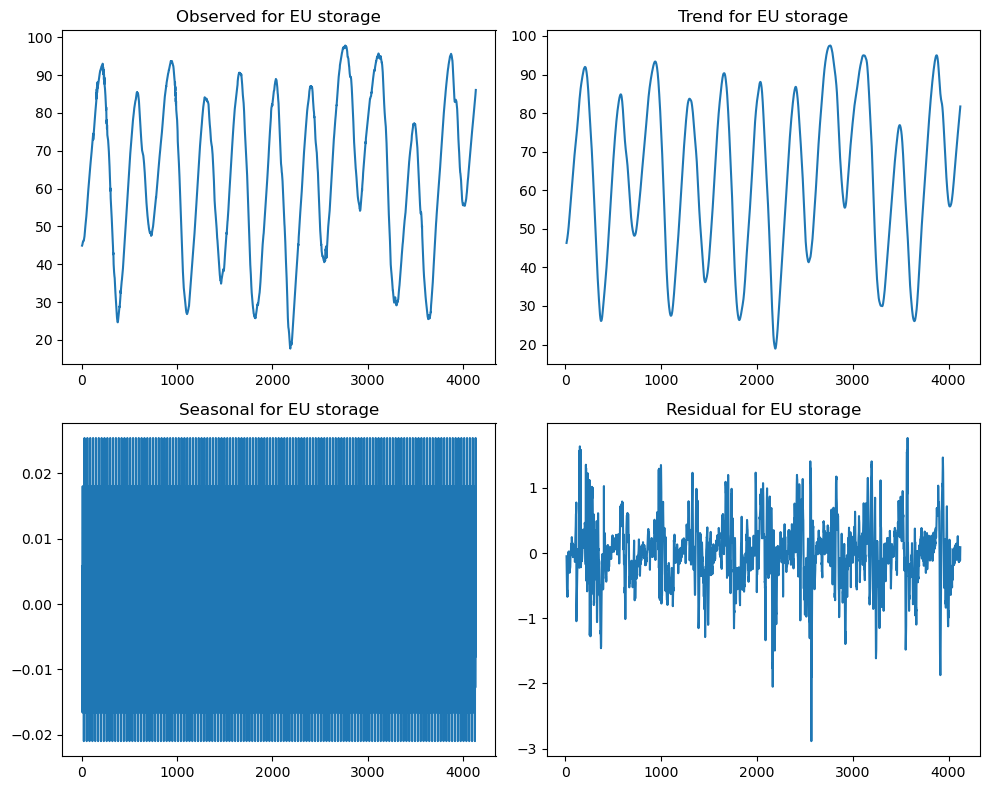

After seasonal decomposition, the residuals for 'EU storage' are stationary.
Trend for EU LNG :
0      NaN
1      NaN
2      NaN
3      NaN
4      NaN
        ..
4134   NaN
4135   NaN
4136   NaN
4137   NaN
4138   NaN
Name: trend, Length: 4139, dtype: float64

Seasonal for EU LNG :
0        4.636221
1        8.588898
2        0.339117
3       -8.723949
4        3.669907
          ...    
4134    -0.454351
4135     8.315078
4136    -1.214521
4137    17.525868
4138    17.786890
Name: seasonal, Length: 4139, dtype: float64

Residual for EU LNG :
0      NaN
1      NaN
2      NaN
3      NaN
4      NaN
        ..
4134   NaN
4135   NaN
4136   NaN
4137   NaN
4138   NaN
Name: resid, Length: 4139, dtype: float64

Observed for EU LNG :
0       1463.5
1       1958.9
2       2331.3
3       2258.8
4       2259.7
         ...  
4134    3281.0
4135    3274.7
4136    3235.9
4137    3091.4
4138    3267.2
Name: EU LNG, Length: 4139, dtype: float64


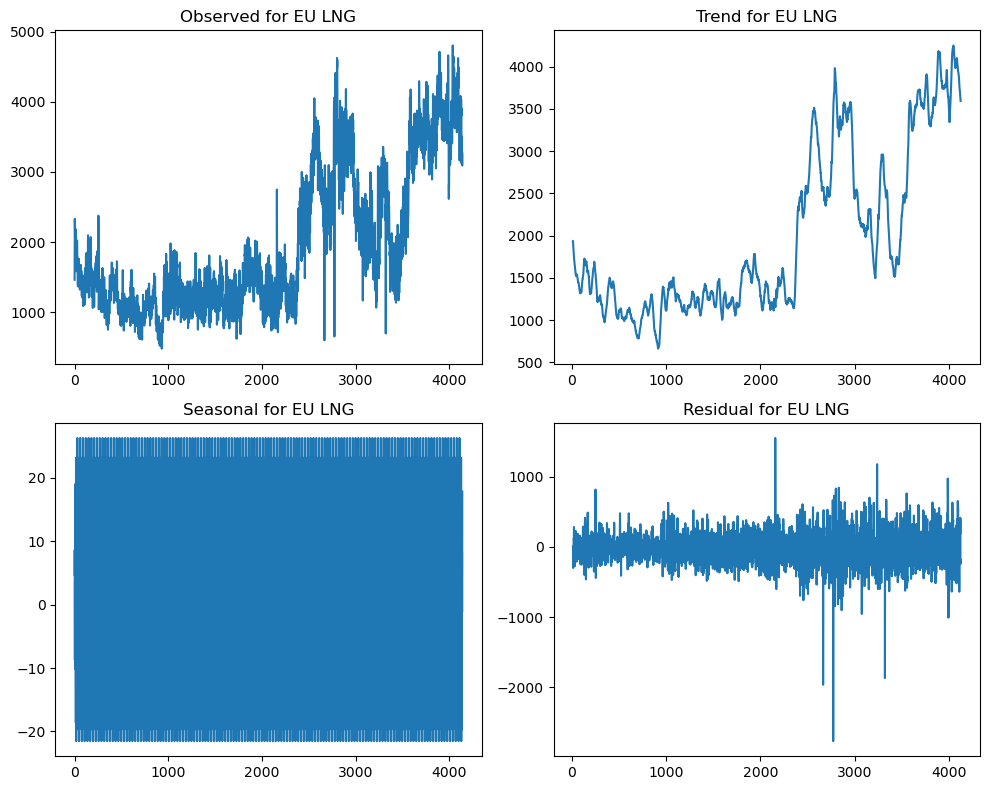

After seasonal decomposition, the residuals for 'EU LNG' are stationary.
Trend for UK NL production :
1247   NaN
1248   NaN
1249   NaN
1250   NaN
1251   NaN
        ..
4134   NaN
4135   NaN
4136   NaN
4137   NaN
4138   NaN
Name: trend, Length: 2892, dtype: float64

Seasonal for UK NL production :
1247    1.612373
1248    2.005055
1249    1.030568
1250    2.008821
1251   -0.745585
          ...   
4134    1.991476
4135    1.196373
4136   -0.562313
4137   -1.976860
4138   -1.878771
Name: seasonal, Length: 2892, dtype: float64

Residual for UK NL production :
1247   NaN
1248   NaN
1249   NaN
1250   NaN
1251   NaN
        ..
4134   NaN
4135   NaN
4136   NaN
4137   NaN
4138   NaN
Name: resid, Length: 2892, dtype: float64

Observed for UK NL production :
1247    209.610
1248    200.710
1249    206.640
1250    221.170
1251    202.810
         ...   
4134    103.175
4135    115.187
4136    122.815
4137    112.772
4138    106.139
Name: UK NL production, Length: 2892, dtype: float64


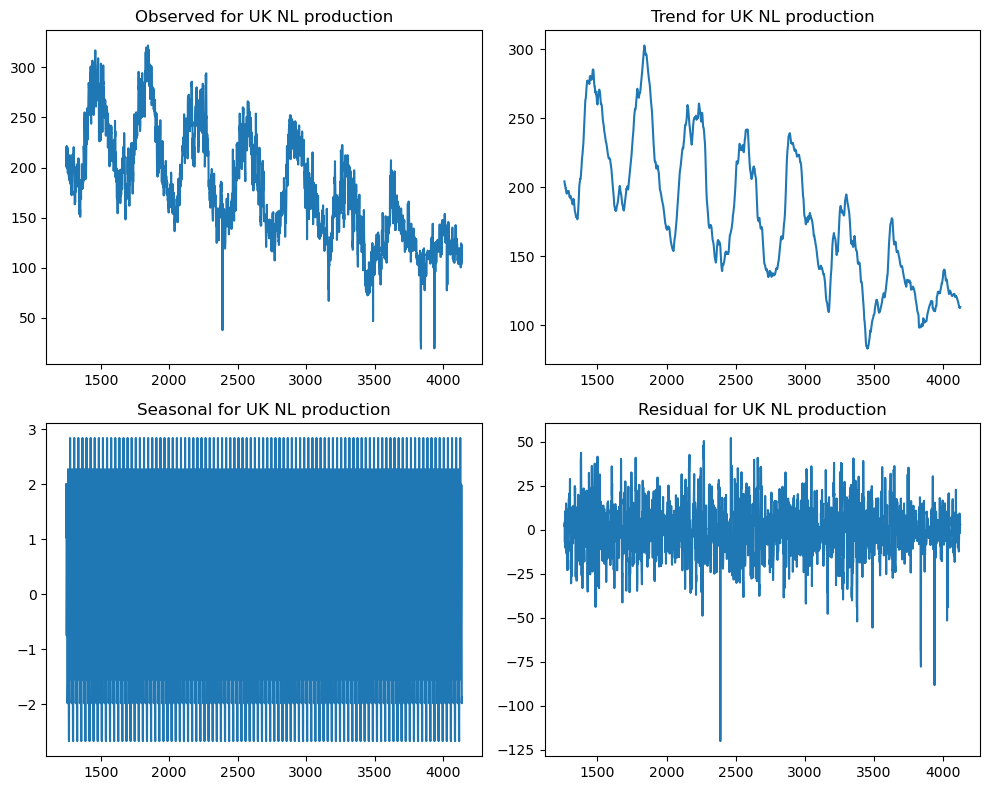

After seasonal decomposition, the residuals for 'UK NL production' are stationary.
Trend for Norway sendout :
3257   NaN
3258   NaN
3259   NaN
3260   NaN
3261   NaN
        ..
4134   NaN
4135   NaN
4136   NaN
4137   NaN
4138   NaN
Name: trend, Length: 882, dtype: float64

Seasonal for Norway sendout :
3257   -0.720859
3258    1.129736
3259    0.172593
3260    0.560807
3261    2.542593
          ...   
4134    3.346641
4135    5.326938
4136    7.272415
4137   -0.019193
4138    3.050331
Name: seasonal, Length: 882, dtype: float64

Residual for Norway sendout :
3257   NaN
3258   NaN
3259   NaN
3260   NaN
3261   NaN
        ..
4134   NaN
4135   NaN
4136   NaN
4137   NaN
4138   NaN
Name: resid, Length: 882, dtype: float64

Observed for Norway sendout :
3257    354.6
3258    357.7
3259    349.6
3260    351.8
3261    347.1
        ...  
4134    298.0
4135    293.3
4136    294.2
4137    289.4
4138    296.4
Name: Norway sendout, Length: 882, dtype: float64


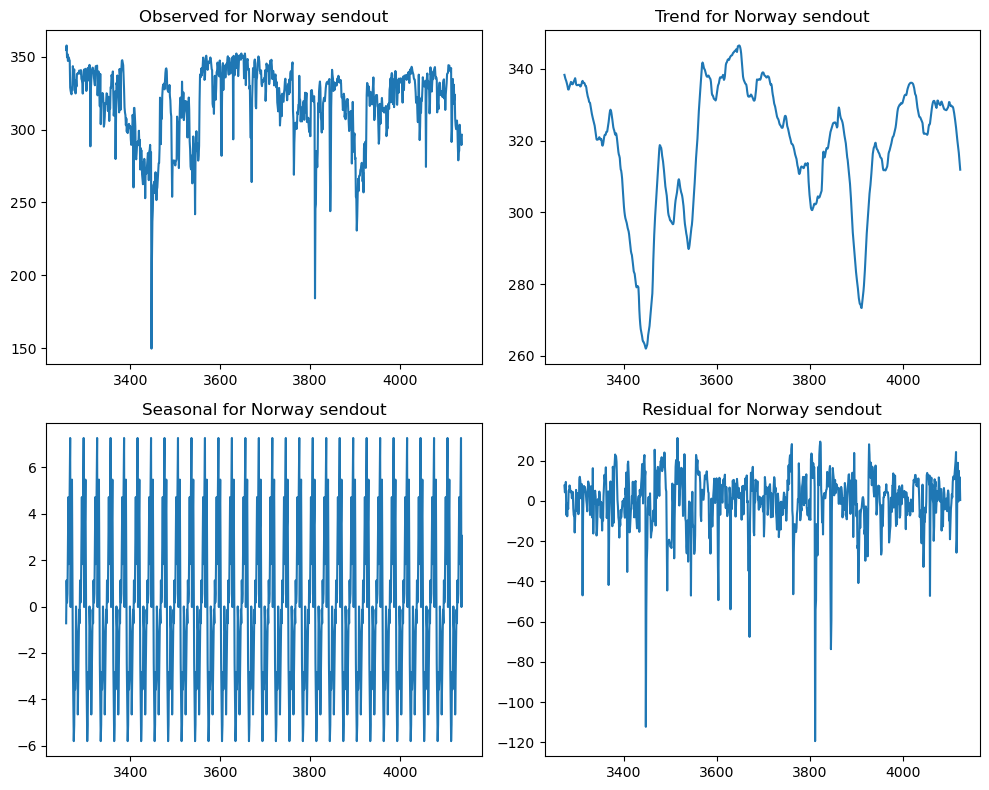

After seasonal decomposition, the residuals for 'Norway sendout' are stationary.
Trend for African TAP :
0      NaN
1      NaN
2      NaN
3      NaN
4      NaN
        ..
4134   NaN
4135   NaN
4136   NaN
4137   NaN
4138   NaN
Name: trend, Length: 4139, dtype: float64

Seasonal for African TAP :
0      -0.180457
1      -0.418674
2       0.022791
3      -0.128316
4       0.189685
          ...   
4134    0.498297
4135    0.089369
4136   -0.374314
4137   -0.329911
4138   -0.769239
Name: seasonal, Length: 4139, dtype: float64

Residual for African TAP :
0      NaN
1      NaN
2      NaN
3      NaN
4      NaN
        ..
4134   NaN
4135   NaN
4136   NaN
4137   NaN
4138   NaN
Name: resid, Length: 4139, dtype: float64

Observed for African TAP :
0       36.2617
1       64.5416
2       64.3773
3       63.0718
4       64.7125
         ...   
4134    98.9927
4135    95.6458
4136    94.5705
4137    90.6178
4138    95.6709
Name: African TAP, Length: 4139, dtype: float64


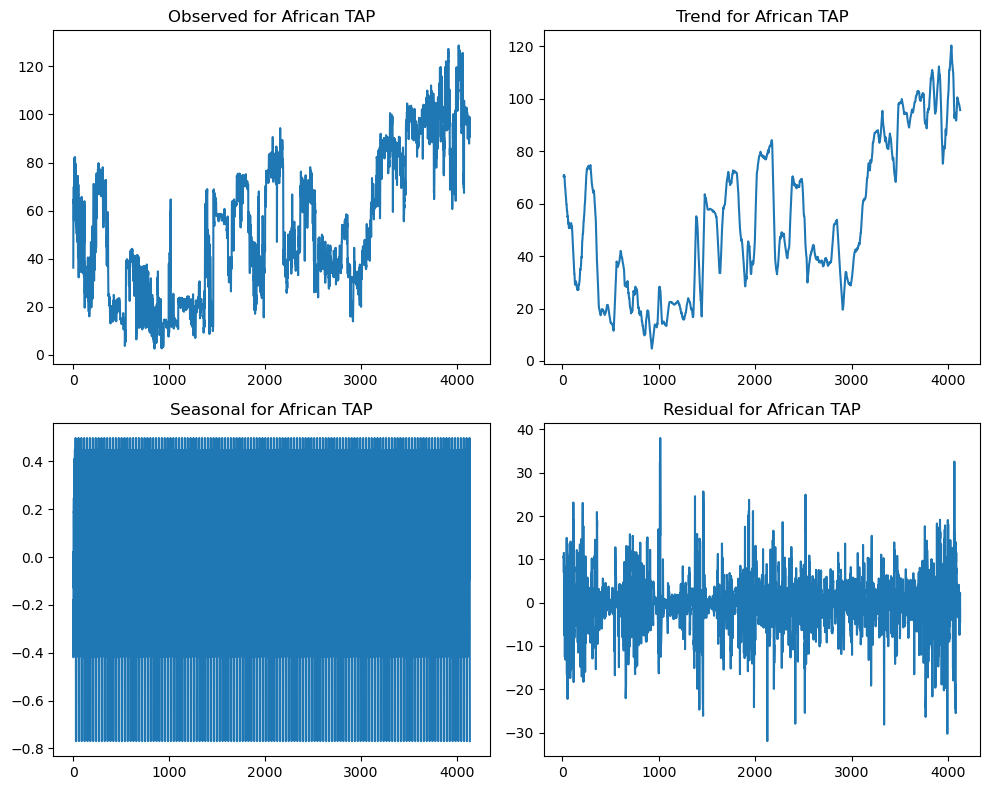

After seasonal decomposition, the residuals for 'African TAP' are stationary.


<Figure size 640x480 with 0 Axes>


Saved the transformed data to 'seasonal_decom_stationary_daily_NGD.csv'.


In [79]:
# seasonal_decom_stationary

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd


def adf_test(timeseries):
    try:
        result = ts.adfuller(timeseries.dropna(), autolag="AIC")
        return result[1] <= 0.05
    except:
        return False


def decompose_and_plot(series, period, series_name, ax):
    """
    Decomposes the given time series into its trend, seasonal, and residual components,
    and then plots them in a 1x4 grid.
    """
    series_dropped = series.dropna()
    result = seasonal.seasonal_decompose(
        series_dropped, model="additive", period=period
    )

    components = {
        "Observed": result.observed,
        "Trend": result.trend,
        "Seasonal": result.seasonal,
        "Residual": result.resid,
    }

    # Plotting the components
    for idx, (label, component) in enumerate(components.items()):
        ax[idx].plot(series_dropped.index, component)
        ax[idx].set_title(f"{label} for {series_name}")
        ax[idx].set_xlabel("Date")
        ax[idx].set_ylabel(label)


# Set up the overall plotting grid
fig, axes = plt.subplots(len(cols_to_check), 4, figsize=(20, 4 * len(cols_to_check)))

for idx, col in enumerate(cols_to_check):
    decompose_and_plot(ngd_data[col], 30, col, axes[idx])

plt.tight_layout()
plt.show()

ngd_data = pd.read_csv("daily_NGD.csv", delimiter=",")
ngd_data["Date"] = pd.to_datetime(ngd_data["Date"])

cols_to_check = [
    "NGD",
    "LDZ",
    "GTP",
    "IND",
    "HDD",
    "HDD-1",
    "Rus",
    "Workday",
    "War",
    "FR nuclear",
    "DE wind",
    "DE solar",
    "THE price",
    "DE IND index",
    "EU storage",
    "EU LNG",
    "UK NL production",
    "Norway sendout",
    "African TAP",
]

# Creating a DataFrame to save transformed data
transformed_data = pd.DataFrame()
transformed_data["Date"] = ngd_data["Date"]

fig, axes = plt.subplots(7, 3, figsize=(15, 25))  # 3x3 layout for 9 series

for idx, col in enumerate(cols_to_check):
    ax = axes[idx // 3, idx % 3]

    decompose_and_print(ngd_data[col], 30, col)

    # Original data
    ax.plot(ngd_data["Date"], ngd_data[col], label="Original", color="blue")

    # Apply seasonal decomposition
    decomposed = seasonal.seasonal_decompose(
        ngd_data[col].dropna(), model="additive", period=30
    )

    # Check if the residuals from the decomposition are stationary
    is_stationary = adf_test(decomposed.resid)

    if is_stationary:
        print(
            f"After seasonal decomposition, the residuals for '{col}' are stationary."
        )
        transformed_data[col] = decomposed.resid
    else:
        print(
            f"Even after seasonal decomposition, the residuals for '{col}' are not stationary."
        )
        transformed_data[col] = decomposed.resid.diff()  # difference the residuals

    # Create a mask for non-NaN values in the transformed data
    mask = ~transformed_data[col].isna()

    # Plotting the transformed data
    ax.plot(
        ngd_data["Date"][mask],
        transformed_data[col].dropna(),
        label="Transformed",
        color="red",
    )
    ax.title.set_text(f"{col} - Original vs. Transformed")
    ax.legend()

plt.tight_layout()
plt.show()

transformed_data.to_csv("seasonal_decom_stationary_daily_NGD.csv", index=False)
print("\nSaved the transformed data to 'seasonal_decom_stationary_daily_NGD.csv'.")

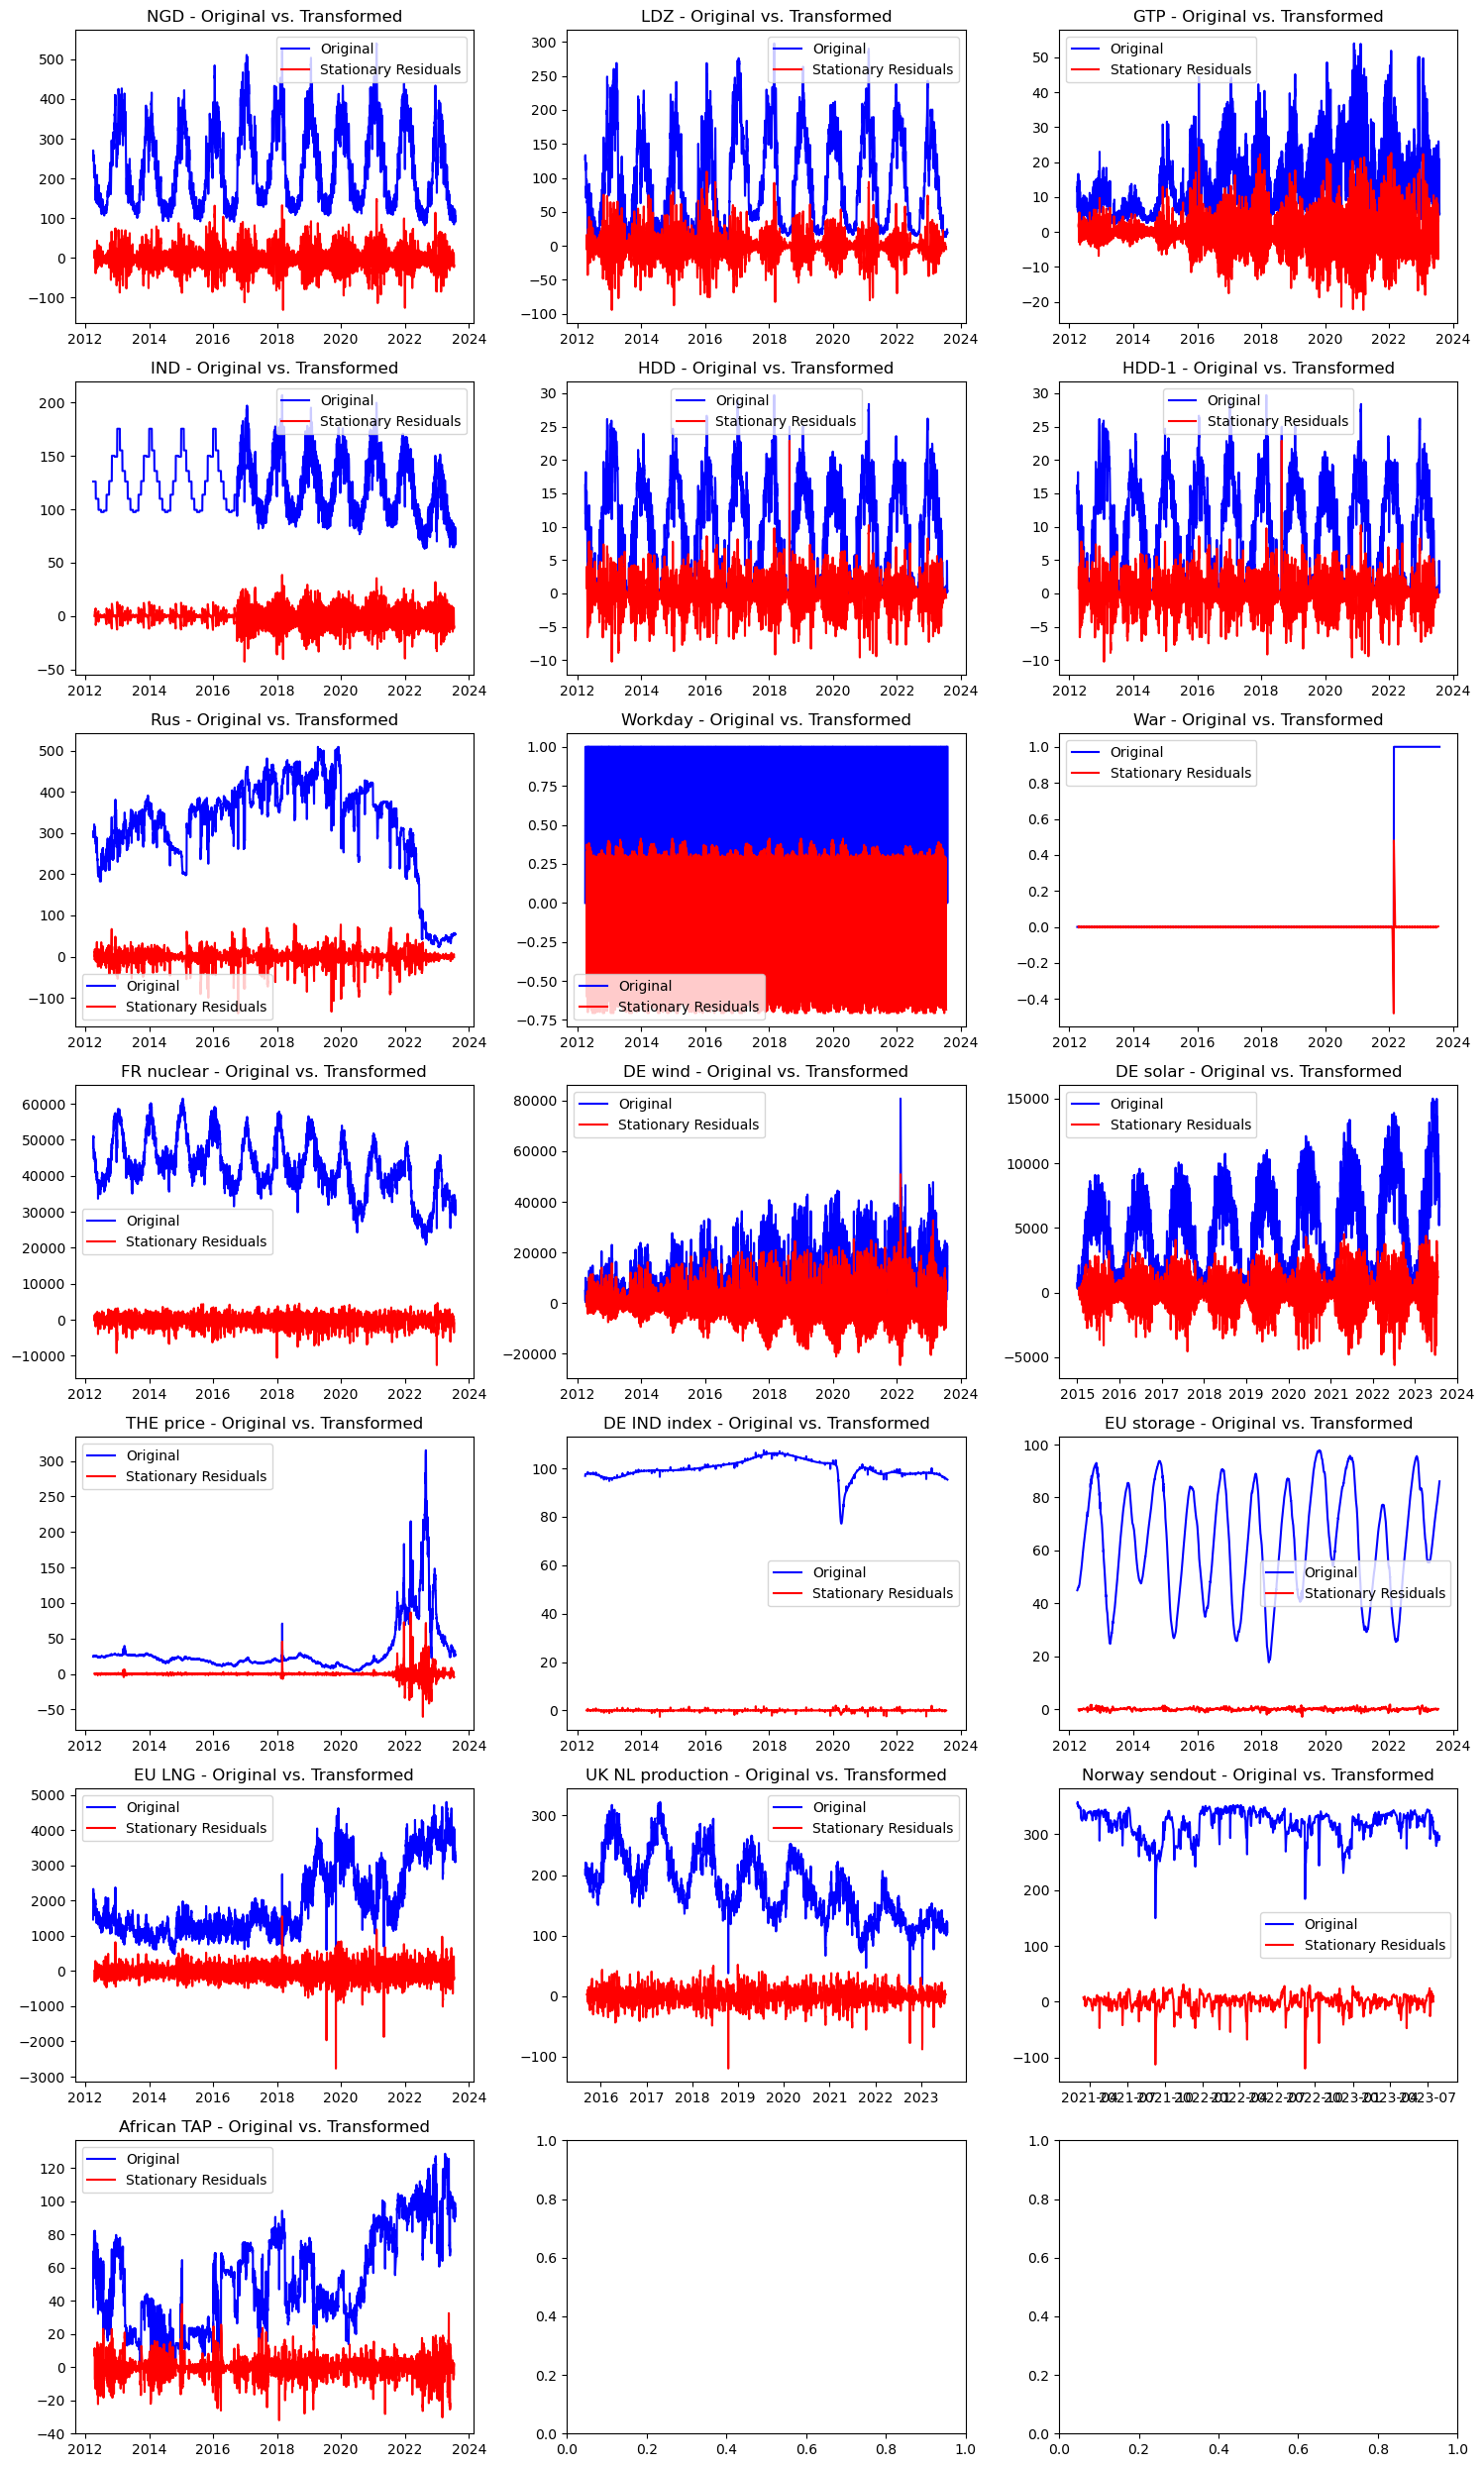

Saved the transformed data to 'transformed_daily_NGD.csv'.
Saved the ADF test results to 'adf_results_before.csv' and 'adf_results_after.csv'.


In [4]:
import matplotlib.pyplot as plt
import pandas as pd


# Function for performing the Augmented Dickey-Fuller test
def adf_test(timeseries):
    result = ts.adfuller(timeseries, autolag="AIC")
    return result  # return the full result


# Reading the data
ngd_data = pd.read_csv("daily_NGD.csv", delimiter=",")
ngd_data["Date"] = pd.to_datetime(ngd_data["Date"])

# Define the columns to check for stationarity
cols_to_check = [
    "NGD",
    "LDZ",
    "GTP",
    "IND",
    "HDD",
    "HDD-1",
    "Rus",
    "Workday",
    "War",
    "FR nuclear",
    "DE wind",
    "DE solar",
    "THE price",
    "DE IND index",
    "EU storage",
    "EU LNG",
    "UK NL production",
    "Norway sendout",
    "African TAP",
]

# Prepare DataFrames to store ADF test results before and after transformation
adf_results_before = pd.DataFrame(
    columns=["Variable", "ADF_Stat", "P_Value", "Stationary_Before"]
)
adf_results_after = pd.DataFrame(
    columns=["Variable", "ADF_Stat", "P_Value", "Stationary_After"]
)

# Create a DataFrame to hold transformed data
transformed_data = pd.DataFrame()
transformed_data["Date"] = ngd_data["Date"]

# Initialize figure for plotting
fig, axes = plt.subplots(
    nrows=7, ncols=3, figsize=(15, 25)
)  # Adjust the size as needed
axes = axes.flatten()  # Flatten the array for easy iteration

# Loop through each column, perform tests, and transform data
for idx, col in enumerate(cols_to_check):
    ax = axes[idx]

    # Original data series and corresponding dates after dropping NA values
    series_clean = ngd_data[col].dropna()
    dates_clean = ngd_data["Date"][ngd_data[col].notna()]

    # Perform ADF test on the original clean series
    adf_result = adf_test(series_clean)
    adf_results_before.loc[idx] = [
        col,
        adf_result[0],
        adf_result[1],
        adf_result[1] <= 0.05,
    ]

    # Plot the original series
    ax.plot(dates_clean, series_clean, label="Original", color="blue")

    # Perform seasonal decomposition and ADF test on the residuals
    decomposed = seasonal.seasonal_decompose(series_clean, model="additive", period=30)
    residuals = decomposed.resid.dropna()
    residuals_dates = dates_clean[~decomposed.resid.isna()]

    # Perform ADF test on the residuals
    adf_result_resid = adf_test(residuals)

    # Check if residuals are stationary
    if not adf_result_resid[1] <= 0.05:
        # Difference the residuals if not stationary
        differenced = residuals.diff().dropna()
        differenced_dates = residuals_dates[1:]  # Align dates with differenced data
        adf_result_differenced = adf_test(differenced)
        adf_results_after.loc[idx] = [
            col,
            adf_result_differenced[0],
            adf_result_differenced[1],
            adf_result_differenced[1] <= 0.05,
        ]

        # Plot the differenced data
        ax.plot(differenced_dates, differenced, label="Differenced", color="red")
        transformed_data[col] = differenced
    else:
        # If residuals are stationary, use them directly
        adf_results_after.loc[idx] = [
            col,
            adf_result_resid[0],
            adf_result_resid[1],
            adf_result_resid[1] <= 0.05,
        ]
        ax.plot(residuals_dates, residuals, label="Stationary Residuals", color="red")
        transformed_data[col] = residuals

    # Set the plot title and legend
    ax.set_title(f"{col} - Original vs. Transformed")
    ax.legend()

# Show the plot
plt.tight_layout()
plt.show()

# Save the transformed data and ADF test results
transformed_data.to_csv("transformed_daily_NGD.csv", index=False)
adf_results_before.to_csv("adf_results_before.csv", index=False)
adf_results_after.to_csv("adf_results_after.csv", index=False)

print("Saved the transformed data to 'transformed_daily_NGD.csv'.")
print(
    "Saved the ADF test results to 'adf_results_before.csv' and 'adf_results_after.csv'."
)